In [1]:
import numpy as np

import plotly.graph_objects as go
from plotly.offline import plot

import sympy as sp
from sympy import Symbol
from sympy.tensor.array import Array
import webbrowser

from matplotlib import pyplot as plt

import pygmo as pg

White = (255, 255, 255)
DeepPink = (255, 20, 147)
DarkBlue = (0, 0, 139)
Red = (255, 0, 0)

def normalize(color):
    return np.array(color, dtype=np.double) / 255

def skip_indicies(n, skip):
    return np.concatenate((np.arange(0, n-skip+1, skip, dtype=np.int32), [n - 1]))

In [18]:
#%% Тестовый пример 1 (Параболическая функция)

xs = [Symbol('x' + str(i)) for i in range(2)]
x, y = xs

f = 2 * x ** 2 + x * y + y ** 2 - 3 * x

x0 = np.array([-2., -2.])
lr = 1e0
tol = 1e-5

skip_grad = 1
skip_pygmo = 1

gen = 10
n_pop = 10

x = np.linspace(-2, 2, 50)
y = np.linspace(-2, 2, 50)

print(f)

description = ", (x_1^{(0)}, x_2^{(0)}) = " + "({:.1f}, {:.1f}), ".format(*x0) +\
              "lr = " + "{:.1e}".format(lr)
title_text = "$ " + str(f) + description + " $"

2*x0**2 + x0*x1 - 3*x0 + x1**2


In [27]:
#%% Тестовый пример 2 (Функция Розеброка)

xs = [Symbol('x' + str(i)) for i in range(2)]
x, y = xs
a = 100
f  = a * (y - x ** 2) ** 2 + (1 - x) ** 2

x0 = np.array([-2., -2.])
lr = 1e0
tol = 1e-5

skip_grad = 1000
skip_pygmo = 5

gen = 15
n_pop = 150

x = np.linspace(-2, 2, 50)
y = np.linspace(-2, 2, 50)

print(f)

description = ", (x_1^{(0)}, x_2^{(0)}) = " + "({:.1f}, {:.1f}), ".format(*x0) +\
              "lr = " + "{:.1e}".format(lr)
title_text = "$ " + str(f) + description + " $"

(1 - x0)**2 + 100*(-x0**2 + x1)**2


In [4]:
#%% Тестовый пример 3 (функция Экли)

xs = [Symbol('x' + str(i)) for i in range(2)]
x, y = xs
f  = sp.E - \
     20 * sp.exp(-sp.sqrt((x ** 2 + y ** 2) / 50)) - \
     sp.exp((sp.cos(2 * sp.pi * x) + sp.cos(2 * sp.pi * y)) / 2)

x0 = np.array([-0.5, -1.6])
lr = 1e-1

skip_grad = 1
skip_pygmo = 1

gen = 10
n_pop = 30

x = np.linspace(-2, 2, 100)
y = np.linspace(-2, 2, 100)

print(f)

description = ", (x_1^{(0)}, x_2^{(0)}) = " + "({:.1f}, {:.1f}), ".format(*x0) +\
              "lr = " + "{:.1e}".format(lr)
title_text = "$ " + str(f) + description + " $"

-exp(cos(2*pi*x0)/2 + cos(2*pi*x1)/2) + E - 20*exp(-sqrt(x0**2/50 + x1**2/50))


In [5]:
#%% Градиентный спуск

def expr_eval(expr, x):
    return np.double(expr.subs([(xs[i], x[i]) for i in range(len(xs))]))

def grad_descent(f, x0,
                 lr=1e-2, lr_min=1e-8, 
                 tol=1e-8, 
                 method="rms-prop",
                 beta=0.9,
                 eps=1e-10,
                 callback=lambda n, xn, lr, norm: None):
    
    df = Array([sp.diff(f, _) for _ in xs]) # символьный градиент
    
    xn = np.copy(x0)
    x = [np.copy(xn)]
    t = 0 # номер текущей итерации
    norm = np.linalg.norm(expr_eval(df, xn))
    
    if method.lower() == "const-lr":
        """
        Спуск с постоянным шагом,
        уменьшение шага возможно только, если f(xn_next) >= f(xn)
        """
        while norm >= tol:
            if lr < lr_min: # достишли минимально возможного шага
                return np.array(x)
            
            xn_next = xn - lr * expr_eval(df, xn) # шаг спуска
            
            if expr_eval(f, xn_next) >= expr_eval(f, xn): # механизм уменьшения шага
                lr /= 2
                continue
            
            xn = np.copy(xn_next)
            norm = np.linalg.norm(expr_eval(df, xn))
            
            t += 1 # конец итерации
            callback(t, xn, lr, norm)
            x.append(np.copy(xn))
    
    elif method.lower() == "rmsprop":
        """
        Алгоритм RMSProp
        """
        s = np.zeros_like(xn)
        t = 1 # начинаем с единицы
        
        while norm >= tol:
            if lr < lr_min: # достишли минимально возможного шага
                break
            
            s_next = beta * s + (1 - beta) * expr_eval(df, xn) ** 2
            xn_next = xn - lr * expr_eval(df, xn) / np.sqrt(s_next + eps)  # шаг спуска
            
            if expr_eval(f, xn_next) >= expr_eval(f, xn): # механизм уменьшения шага
                lr /= 2
                continue
            
            s = s_next
            xn = xn_next
            norm = np.linalg.norm(expr_eval(df, xn))
            
            # конец итерации
            
            callback(t, xn, lr, norm)
            t += 1 
            x.append(np.copy(xn))
            
    return np.array(x)

In [24]:
#%% Применяем градиентный спуск

show_progress = True

callback = lambda n, xn, lr, norm: print("n = {:4d} || f = {:.4e} || lr = {:.2e} || norm = {:.2e}".format(n, expr_eval(f, xn), lr, norm)) if show_progress else lambda n, xn, lr, norm: None

grad_res = grad_descent(f, x0, lr, tol=tol,
                        method="rmsprop", beta=0.5, eps=1e-8,
                        callback = callback)
n_grad = grad_res.shape[0]
print("steps_count = {:d}, arg_min = {:s}, min = {:.4f}".format(n_grad - 1, str(grad_res[-1, :]), expr_eval(f, grad_res[-1, :])))

n =    1 || f = 8.8806e+01 || lr = 1.00e+00 || norm = 2.89e+02
n =    2 || f = 3.0050e+01 || lr = 1.00e+00 || norm = 1.50e+02
n =    3 || f = 7.3312e+00 || lr = 1.00e+00 || norm = 6.26e+01
n =    4 || f = 2.2397e+00 || lr = 1.00e+00 || norm = 1.57e+01
n =    5 || f = 1.9142e+00 || lr = 1.00e+00 || norm = 2.23e+00
n =    6 || f = 1.9027e+00 || lr = 1.00e+00 || norm = 2.60e+00
n =    7 || f = 1.8872e+00 || lr = 1.00e+00 || norm = 2.32e+00
n =    8 || f = 1.8658e+00 || lr = 1.00e+00 || norm = 2.78e+00
n =    9 || f = 1.8408e+00 || lr = 1.00e+00 || norm = 2.40e+00
n =   10 || f = 1.8357e+00 || lr = 5.00e-01 || norm = 5.18e+00
n =   11 || f = 1.8215e+00 || lr = 2.50e-01 || norm = 3.52e+00
n =   12 || f = 1.7912e+00 || lr = 1.25e-01 || norm = 3.36e+00
n =   13 || f = 1.7762e+00 || lr = 1.25e-01 || norm = 2.29e+00
n =   14 || f = 1.7641e+00 || lr = 1.25e-01 || norm = 4.29e+00
n =   15 || f = 1.7478e+00 || lr = 6.25e-02 || norm = 2.73e+00
n =   16 || f = 1.7441e+00 || lr = 6.25e-02 || norm = 5

n =  240 || f = 1.3612e-01 || lr = 7.81e-03 || norm = 2.85e+00
n =  241 || f = 1.3575e-01 || lr = 7.81e-03 || norm = 2.96e+00
n =  242 || f = 1.3513e-01 || lr = 7.81e-03 || norm = 2.86e+00
n =  243 || f = 1.3477e-01 || lr = 7.81e-03 || norm = 2.97e+00
n =  244 || f = 1.3416e-01 || lr = 7.81e-03 || norm = 2.86e+00
n =  245 || f = 1.3380e-01 || lr = 7.81e-03 || norm = 2.98e+00
n =  246 || f = 1.3319e-01 || lr = 7.81e-03 || norm = 2.87e+00
n =  247 || f = 1.3284e-01 || lr = 7.81e-03 || norm = 2.98e+00
n =  248 || f = 1.3224e-01 || lr = 7.81e-03 || norm = 2.88e+00
n =  249 || f = 1.3190e-01 || lr = 7.81e-03 || norm = 2.99e+00
n =  250 || f = 1.3130e-01 || lr = 7.81e-03 || norm = 2.89e+00
n =  251 || f = 1.3096e-01 || lr = 7.81e-03 || norm = 3.00e+00
n =  252 || f = 1.3037e-01 || lr = 7.81e-03 || norm = 2.89e+00
n =  253 || f = 1.3004e-01 || lr = 7.81e-03 || norm = 3.01e+00
n =  254 || f = 1.2945e-01 || lr = 7.81e-03 || norm = 2.90e+00
n =  255 || f = 1.2913e-01 || lr = 7.81e-03 || norm = 3

n =  515 || f = 6.3998e-02 || lr = 7.81e-03 || norm = 3.68e+00
n =  516 || f = 6.3736e-02 || lr = 7.81e-03 || norm = 3.58e+00
n =  517 || f = 6.3725e-02 || lr = 7.81e-03 || norm = 3.69e+00
n =  518 || f = 6.3464e-02 || lr = 7.81e-03 || norm = 3.59e+00
n =  519 || f = 6.3454e-02 || lr = 7.81e-03 || norm = 3.69e+00
n =  520 || f = 6.3194e-02 || lr = 7.81e-03 || norm = 3.59e+00
n =  521 || f = 6.3185e-02 || lr = 7.81e-03 || norm = 3.70e+00
n =  522 || f = 6.2926e-02 || lr = 7.81e-03 || norm = 3.59e+00
n =  523 || f = 6.2918e-02 || lr = 7.81e-03 || norm = 3.70e+00
n =  524 || f = 6.2660e-02 || lr = 7.81e-03 || norm = 3.60e+00
n =  525 || f = 6.2653e-02 || lr = 7.81e-03 || norm = 3.70e+00
n =  526 || f = 6.2395e-02 || lr = 7.81e-03 || norm = 3.60e+00
n =  527 || f = 6.2389e-02 || lr = 7.81e-03 || norm = 3.71e+00
n =  528 || f = 6.2133e-02 || lr = 7.81e-03 || norm = 3.61e+00
n =  529 || f = 6.2128e-02 || lr = 7.81e-03 || norm = 3.71e+00
n =  530 || f = 6.1872e-02 || lr = 7.81e-03 || norm = 3

n =  653 || f = 3.5630e-02 || lr = 9.77e-04 || norm = 5.05e-01
n =  654 || f = 3.5516e-02 || lr = 9.77e-04 || norm = 4.23e-01
n =  655 || f = 3.5434e-02 || lr = 9.77e-04 || norm = 5.05e-01
n =  656 || f = 3.5321e-02 || lr = 9.77e-04 || norm = 4.24e-01
n =  657 || f = 3.5240e-02 || lr = 9.77e-04 || norm = 5.06e-01
n =  658 || f = 3.5128e-02 || lr = 9.77e-04 || norm = 4.24e-01
n =  659 || f = 3.5047e-02 || lr = 9.77e-04 || norm = 5.07e-01
n =  660 || f = 3.4936e-02 || lr = 9.77e-04 || norm = 4.25e-01
n =  661 || f = 3.4856e-02 || lr = 9.77e-04 || norm = 5.07e-01
n =  662 || f = 3.4746e-02 || lr = 9.77e-04 || norm = 4.25e-01
n =  663 || f = 3.4667e-02 || lr = 9.77e-04 || norm = 5.08e-01
n =  664 || f = 3.4557e-02 || lr = 9.77e-04 || norm = 4.26e-01
n =  665 || f = 3.4479e-02 || lr = 9.77e-04 || norm = 5.08e-01
n =  666 || f = 3.4370e-02 || lr = 9.77e-04 || norm = 4.27e-01
n =  667 || f = 3.4292e-02 || lr = 9.77e-04 || norm = 5.09e-01
n =  668 || f = 3.4184e-02 || lr = 9.77e-04 || norm = 4

n =  784 || f = 2.5460e-02 || lr = 9.77e-04 || norm = 4.58e-01
n =  785 || f = 2.5409e-02 || lr = 9.77e-04 || norm = 5.36e-01
n =  786 || f = 2.5338e-02 || lr = 9.77e-04 || norm = 4.58e-01
n =  787 || f = 2.5287e-02 || lr = 9.77e-04 || norm = 5.36e-01
n =  788 || f = 2.5217e-02 || lr = 9.77e-04 || norm = 4.58e-01
n =  789 || f = 2.5166e-02 || lr = 9.77e-04 || norm = 5.37e-01
n =  790 || f = 2.5096e-02 || lr = 9.77e-04 || norm = 4.59e-01
n =  791 || f = 2.5046e-02 || lr = 9.77e-04 || norm = 5.37e-01
n =  792 || f = 2.4977e-02 || lr = 9.77e-04 || norm = 4.59e-01
n =  793 || f = 2.4927e-02 || lr = 9.77e-04 || norm = 5.37e-01
n =  794 || f = 2.4858e-02 || lr = 9.77e-04 || norm = 4.60e-01
n =  795 || f = 2.4809e-02 || lr = 9.77e-04 || norm = 5.38e-01
n =  796 || f = 2.4740e-02 || lr = 9.77e-04 || norm = 4.60e-01
n =  797 || f = 2.4691e-02 || lr = 9.77e-04 || norm = 5.38e-01
n =  798 || f = 2.4623e-02 || lr = 9.77e-04 || norm = 4.61e-01
n =  799 || f = 2.4574e-02 || lr = 9.77e-04 || norm = 5

n =  916 || f = 1.8826e-02 || lr = 9.77e-04 || norm = 4.85e-01
n =  917 || f = 1.8792e-02 || lr = 9.77e-04 || norm = 5.56e-01
n =  918 || f = 1.8744e-02 || lr = 9.77e-04 || norm = 4.85e-01
n =  919 || f = 1.8710e-02 || lr = 9.77e-04 || norm = 5.56e-01
n =  920 || f = 1.8663e-02 || lr = 9.77e-04 || norm = 4.86e-01
n =  921 || f = 1.8628e-02 || lr = 9.77e-04 || norm = 5.57e-01
n =  922 || f = 1.8581e-02 || lr = 9.77e-04 || norm = 4.86e-01
n =  923 || f = 1.8547e-02 || lr = 9.77e-04 || norm = 5.57e-01
n =  924 || f = 1.8501e-02 || lr = 9.77e-04 || norm = 4.87e-01
n =  925 || f = 1.8467e-02 || lr = 9.77e-04 || norm = 5.57e-01
n =  926 || f = 1.8420e-02 || lr = 9.77e-04 || norm = 4.87e-01
n =  927 || f = 1.8387e-02 || lr = 9.77e-04 || norm = 5.58e-01
n =  928 || f = 1.8340e-02 || lr = 9.77e-04 || norm = 4.87e-01
n =  929 || f = 1.8307e-02 || lr = 9.77e-04 || norm = 5.58e-01
n =  930 || f = 1.8261e-02 || lr = 9.77e-04 || norm = 4.88e-01
n =  931 || f = 1.8228e-02 || lr = 9.77e-04 || norm = 5

n = 1107 || f = 1.2658e-02 || lr = 9.77e-04 || norm = 5.77e-01
n = 1108 || f = 1.2629e-02 || lr = 9.77e-04 || norm = 5.16e-01
n = 1109 || f = 1.2608e-02 || lr = 9.77e-04 || norm = 5.77e-01
n = 1110 || f = 1.2579e-02 || lr = 9.77e-04 || norm = 5.16e-01
n = 1111 || f = 1.2558e-02 || lr = 9.77e-04 || norm = 5.77e-01
n = 1112 || f = 1.2529e-02 || lr = 9.77e-04 || norm = 5.17e-01
n = 1113 || f = 1.2508e-02 || lr = 9.77e-04 || norm = 5.77e-01
n = 1114 || f = 1.2480e-02 || lr = 9.77e-04 || norm = 5.17e-01
n = 1115 || f = 1.2459e-02 || lr = 9.77e-04 || norm = 5.77e-01
n = 1116 || f = 1.2430e-02 || lr = 9.77e-04 || norm = 5.17e-01
n = 1117 || f = 1.2409e-02 || lr = 9.77e-04 || norm = 5.77e-01
n = 1118 || f = 1.2381e-02 || lr = 9.77e-04 || norm = 5.18e-01
n = 1119 || f = 1.2360e-02 || lr = 9.77e-04 || norm = 5.78e-01
n = 1120 || f = 1.2332e-02 || lr = 9.77e-04 || norm = 5.18e-01
n = 1121 || f = 1.2312e-02 || lr = 9.77e-04 || norm = 5.78e-01
n = 1122 || f = 1.2284e-02 || lr = 9.77e-04 || norm = 5

n = 1326 || f = 8.3329e-03 || lr = 9.77e-04 || norm = 5.43e-01
n = 1327 || f = 8.3196e-03 || lr = 9.77e-04 || norm = 5.93e-01
n = 1328 || f = 8.3023e-03 || lr = 9.77e-04 || norm = 5.43e-01
n = 1329 || f = 8.2891e-03 || lr = 9.77e-04 || norm = 5.93e-01
n = 1330 || f = 8.2719e-03 || lr = 9.77e-04 || norm = 5.43e-01
n = 1331 || f = 8.2587e-03 || lr = 9.77e-04 || norm = 5.93e-01
n = 1332 || f = 8.2416e-03 || lr = 9.77e-04 || norm = 5.43e-01
n = 1333 || f = 8.2285e-03 || lr = 9.77e-04 || norm = 5.93e-01
n = 1334 || f = 8.2115e-03 || lr = 9.77e-04 || norm = 5.44e-01
n = 1335 || f = 8.1984e-03 || lr = 9.77e-04 || norm = 5.94e-01
n = 1336 || f = 8.1815e-03 || lr = 9.77e-04 || norm = 5.44e-01
n = 1337 || f = 8.1684e-03 || lr = 9.77e-04 || norm = 5.94e-01
n = 1338 || f = 8.1516e-03 || lr = 9.77e-04 || norm = 5.44e-01
n = 1339 || f = 8.1386e-03 || lr = 9.77e-04 || norm = 5.94e-01
n = 1340 || f = 8.1218e-03 || lr = 9.77e-04 || norm = 5.44e-01
n = 1341 || f = 8.1089e-03 || lr = 9.77e-04 || norm = 5

n = 1457 || f = 6.5830e-03 || lr = 9.77e-04 || norm = 6.01e-01
n = 1458 || f = 6.5699e-03 || lr = 9.77e-04 || norm = 5.56e-01
n = 1459 || f = 6.5598e-03 || lr = 9.77e-04 || norm = 6.01e-01
n = 1460 || f = 6.5468e-03 || lr = 9.77e-04 || norm = 5.56e-01
n = 1461 || f = 6.5366e-03 || lr = 9.77e-04 || norm = 6.01e-01
n = 1462 || f = 6.5237e-03 || lr = 9.77e-04 || norm = 5.56e-01
n = 1463 || f = 6.5136e-03 || lr = 9.77e-04 || norm = 6.01e-01
n = 1464 || f = 6.5007e-03 || lr = 9.77e-04 || norm = 5.56e-01
n = 1465 || f = 6.4907e-03 || lr = 9.77e-04 || norm = 6.01e-01
n = 1466 || f = 6.4778e-03 || lr = 9.77e-04 || norm = 5.56e-01
n = 1467 || f = 6.4678e-03 || lr = 9.77e-04 || norm = 6.01e-01
n = 1468 || f = 6.4550e-03 || lr = 9.77e-04 || norm = 5.57e-01
n = 1469 || f = 6.4451e-03 || lr = 9.77e-04 || norm = 6.01e-01
n = 1470 || f = 6.4323e-03 || lr = 9.77e-04 || norm = 5.57e-01
n = 1471 || f = 6.4224e-03 || lr = 9.77e-04 || norm = 6.01e-01
n = 1472 || f = 6.4097e-03 || lr = 9.77e-04 || norm = 5

n = 1686 || f = 4.4444e-03 || lr = 9.77e-04 || norm = 5.74e-01
n = 1687 || f = 4.4379e-03 || lr = 9.77e-04 || norm = 6.11e-01
n = 1688 || f = 4.4296e-03 || lr = 9.77e-04 || norm = 5.74e-01
n = 1689 || f = 4.4231e-03 || lr = 9.77e-04 || norm = 6.11e-01
n = 1690 || f = 4.4149e-03 || lr = 9.77e-04 || norm = 5.74e-01
n = 1691 || f = 4.4084e-03 || lr = 9.77e-04 || norm = 6.12e-01
n = 1692 || f = 4.4002e-03 || lr = 9.77e-04 || norm = 5.75e-01
n = 1693 || f = 4.3938e-03 || lr = 9.77e-04 || norm = 6.12e-01
n = 1694 || f = 4.3856e-03 || lr = 9.77e-04 || norm = 5.75e-01
n = 1695 || f = 4.3792e-03 || lr = 9.77e-04 || norm = 6.12e-01
n = 1696 || f = 4.3711e-03 || lr = 9.77e-04 || norm = 5.75e-01
n = 1697 || f = 4.3647e-03 || lr = 9.77e-04 || norm = 6.12e-01
n = 1698 || f = 4.3566e-03 || lr = 9.77e-04 || norm = 5.75e-01
n = 1699 || f = 4.3502e-03 || lr = 9.77e-04 || norm = 6.12e-01
n = 1700 || f = 4.3421e-03 || lr = 9.77e-04 || norm = 5.75e-01
n = 1701 || f = 4.3358e-03 || lr = 9.77e-04 || norm = 6

n = 1987 || f = 2.7416e-03 || lr = 9.77e-04 || norm = 6.22e-01
n = 1988 || f = 2.7368e-03 || lr = 9.77e-04 || norm = 5.93e-01
n = 1989 || f = 2.7331e-03 || lr = 9.77e-04 || norm = 6.22e-01
n = 1990 || f = 2.7284e-03 || lr = 9.77e-04 || norm = 5.93e-01
n = 1991 || f = 2.7247e-03 || lr = 9.77e-04 || norm = 6.22e-01
n = 1992 || f = 2.7199e-03 || lr = 9.77e-04 || norm = 5.93e-01
n = 1993 || f = 2.7163e-03 || lr = 9.77e-04 || norm = 6.22e-01
n = 1994 || f = 2.7116e-03 || lr = 9.77e-04 || norm = 5.93e-01
n = 1995 || f = 2.7079e-03 || lr = 9.77e-04 || norm = 6.22e-01
n = 1996 || f = 2.7032e-03 || lr = 9.77e-04 || norm = 5.93e-01
n = 1997 || f = 2.6996e-03 || lr = 9.77e-04 || norm = 6.22e-01
n = 1998 || f = 2.6949e-03 || lr = 9.77e-04 || norm = 5.93e-01
n = 1999 || f = 2.6912e-03 || lr = 9.77e-04 || norm = 6.22e-01
n = 2000 || f = 2.6866e-03 || lr = 9.77e-04 || norm = 5.93e-01
n = 2001 || f = 2.6830e-03 || lr = 9.77e-04 || norm = 6.22e-01
n = 2002 || f = 2.6783e-03 || lr = 9.77e-04 || norm = 5

n = 2239 || f = 1.8790e-03 || lr = 9.77e-04 || norm = 6.28e-01
n = 2240 || f = 1.8759e-03 || lr = 9.77e-04 || norm = 6.05e-01
n = 2241 || f = 1.8736e-03 || lr = 9.77e-04 || norm = 6.28e-01
n = 2242 || f = 1.8704e-03 || lr = 9.77e-04 || norm = 6.05e-01
n = 2243 || f = 1.8681e-03 || lr = 9.77e-04 || norm = 6.28e-01
n = 2244 || f = 1.8650e-03 || lr = 9.77e-04 || norm = 6.05e-01
n = 2245 || f = 1.8627e-03 || lr = 9.77e-04 || norm = 6.28e-01
n = 2246 || f = 1.8596e-03 || lr = 9.77e-04 || norm = 6.05e-01
n = 2247 || f = 1.8573e-03 || lr = 9.77e-04 || norm = 6.29e-01
n = 2248 || f = 1.8542e-03 || lr = 9.77e-04 || norm = 6.05e-01
n = 2249 || f = 1.8520e-03 || lr = 9.77e-04 || norm = 6.29e-01
n = 2250 || f = 1.8489e-03 || lr = 9.77e-04 || norm = 6.05e-01
n = 2251 || f = 1.8466e-03 || lr = 9.77e-04 || norm = 6.29e-01
n = 2252 || f = 1.8436e-03 || lr = 9.77e-04 || norm = 6.05e-01
n = 2253 || f = 1.8413e-03 || lr = 9.77e-04 || norm = 6.29e-01
n = 2254 || f = 1.8382e-03 || lr = 9.77e-04 || norm = 6

n = 2552 || f = 1.2177e-03 || lr = 9.77e-04 || norm = 6.16e-01
n = 2553 || f = 1.2164e-03 || lr = 9.77e-04 || norm = 6.35e-01
n = 2554 || f = 1.2145e-03 || lr = 9.77e-04 || norm = 6.16e-01
n = 2555 || f = 1.2132e-03 || lr = 9.77e-04 || norm = 6.35e-01
n = 2556 || f = 1.2113e-03 || lr = 9.77e-04 || norm = 6.16e-01
n = 2557 || f = 1.2100e-03 || lr = 9.77e-04 || norm = 6.35e-01
n = 2558 || f = 1.2081e-03 || lr = 9.77e-04 || norm = 6.16e-01
n = 2559 || f = 1.2068e-03 || lr = 9.77e-04 || norm = 6.35e-01
n = 2560 || f = 1.2049e-03 || lr = 9.77e-04 || norm = 6.16e-01
n = 2561 || f = 1.2037e-03 || lr = 9.77e-04 || norm = 6.35e-01
n = 2562 || f = 1.2018e-03 || lr = 9.77e-04 || norm = 6.16e-01
n = 2563 || f = 1.2005e-03 || lr = 9.77e-04 || norm = 6.35e-01
n = 2564 || f = 1.1986e-03 || lr = 9.77e-04 || norm = 6.16e-01
n = 2565 || f = 1.1974e-03 || lr = 9.77e-04 || norm = 6.35e-01
n = 2566 || f = 1.1955e-03 || lr = 9.77e-04 || norm = 6.16e-01
n = 2567 || f = 1.1942e-03 || lr = 9.77e-04 || norm = 6

n = 2684 || f = 1.0275e-03 || lr = 9.77e-04 || norm = 6.20e-01
n = 2685 || f = 1.0265e-03 || lr = 9.77e-04 || norm = 6.37e-01
n = 2686 || f = 1.0249e-03 || lr = 9.77e-04 || norm = 6.20e-01
n = 2687 || f = 1.0240e-03 || lr = 9.77e-04 || norm = 6.37e-01
n = 2688 || f = 1.0224e-03 || lr = 9.77e-04 || norm = 6.20e-01
n = 2689 || f = 1.0214e-03 || lr = 9.77e-04 || norm = 6.37e-01
n = 2690 || f = 1.0198e-03 || lr = 9.77e-04 || norm = 6.20e-01
n = 2691 || f = 1.0188e-03 || lr = 9.77e-04 || norm = 6.37e-01
n = 2692 || f = 1.0173e-03 || lr = 9.77e-04 || norm = 6.20e-01
n = 2693 || f = 1.0163e-03 || lr = 9.77e-04 || norm = 6.37e-01
n = 2694 || f = 1.0147e-03 || lr = 9.77e-04 || norm = 6.20e-01
n = 2695 || f = 1.0138e-03 || lr = 9.77e-04 || norm = 6.37e-01
n = 2696 || f = 1.0122e-03 || lr = 9.77e-04 || norm = 6.20e-01
n = 2697 || f = 1.0112e-03 || lr = 9.77e-04 || norm = 6.37e-01
n = 2698 || f = 1.0097e-03 || lr = 9.77e-04 || norm = 6.20e-01
n = 2699 || f = 1.0087e-03 || lr = 9.77e-04 || norm = 6

n = 3092 || f = 6.4302e-04 || lr = 9.77e-04 || norm = 6.30e-01
n = 3093 || f = 6.4265e-04 || lr = 9.77e-04 || norm = 6.42e-01
n = 3094 || f = 6.4169e-04 || lr = 9.77e-04 || norm = 6.30e-01
n = 3095 || f = 6.4132e-04 || lr = 9.77e-04 || norm = 6.42e-01
n = 3096 || f = 6.4036e-04 || lr = 9.77e-04 || norm = 6.30e-01
n = 3097 || f = 6.3999e-04 || lr = 9.77e-04 || norm = 6.42e-01
n = 3098 || f = 6.3904e-04 || lr = 9.77e-04 || norm = 6.30e-01
n = 3099 || f = 6.3867e-04 || lr = 9.77e-04 || norm = 6.42e-01
n = 3100 || f = 6.3772e-04 || lr = 9.77e-04 || norm = 6.30e-01
n = 3101 || f = 6.3736e-04 || lr = 9.77e-04 || norm = 6.42e-01
n = 3102 || f = 6.3641e-04 || lr = 9.77e-04 || norm = 6.30e-01
n = 3103 || f = 6.3605e-04 || lr = 9.77e-04 || norm = 6.42e-01
n = 3104 || f = 6.3510e-04 || lr = 9.77e-04 || norm = 6.30e-01
n = 3105 || f = 6.3474e-04 || lr = 9.77e-04 || norm = 6.42e-01
n = 3106 || f = 6.3379e-04 || lr = 9.77e-04 || norm = 6.30e-01
n = 3107 || f = 6.3344e-04 || lr = 9.77e-04 || norm = 6

n = 3232 || f = 5.5939e-04 || lr = 9.77e-04 || norm = 6.32e-01
n = 3233 || f = 5.5914e-04 || lr = 9.77e-04 || norm = 6.43e-01
n = 3234 || f = 5.5832e-04 || lr = 9.77e-04 || norm = 6.33e-01
n = 3235 || f = 5.5808e-04 || lr = 9.77e-04 || norm = 6.43e-01
n = 3236 || f = 5.5726e-04 || lr = 9.77e-04 || norm = 6.33e-01
n = 3237 || f = 5.5702e-04 || lr = 9.77e-04 || norm = 6.44e-01
n = 3238 || f = 5.5620e-04 || lr = 9.77e-04 || norm = 6.33e-01
n = 3239 || f = 5.5596e-04 || lr = 9.77e-04 || norm = 6.44e-01
n = 3240 || f = 5.5514e-04 || lr = 9.77e-04 || norm = 6.33e-01
n = 3241 || f = 5.5491e-04 || lr = 9.77e-04 || norm = 6.44e-01
n = 3242 || f = 5.5409e-04 || lr = 9.77e-04 || norm = 6.33e-01
n = 3243 || f = 5.5386e-04 || lr = 9.77e-04 || norm = 6.44e-01
n = 3244 || f = 5.5304e-04 || lr = 9.77e-04 || norm = 6.33e-01
n = 3245 || f = 5.5281e-04 || lr = 9.77e-04 || norm = 6.44e-01
n = 3246 || f = 5.5200e-04 || lr = 9.77e-04 || norm = 6.33e-01
n = 3247 || f = 5.5177e-04 || lr = 9.77e-04 || norm = 6

n = 3505 || f = 4.4131e-04 || lr = 9.77e-04 || norm = 6.46e-01
n = 3506 || f = 4.4068e-04 || lr = 9.77e-04 || norm = 6.37e-01
n = 3507 || f = 4.4061e-04 || lr = 9.77e-04 || norm = 6.46e-01
n = 3508 || f = 4.3998e-04 || lr = 9.77e-04 || norm = 6.37e-01
n = 3509 || f = 4.3992e-04 || lr = 9.77e-04 || norm = 6.46e-01
n = 3510 || f = 4.3929e-04 || lr = 9.77e-04 || norm = 6.37e-01
n = 3511 || f = 4.3923e-04 || lr = 9.77e-04 || norm = 6.46e-01
n = 3512 || f = 4.3861e-04 || lr = 9.77e-04 || norm = 6.37e-01
n = 3513 || f = 4.3855e-04 || lr = 9.77e-04 || norm = 6.46e-01
n = 3514 || f = 4.3792e-04 || lr = 9.77e-04 || norm = 6.37e-01
n = 3515 || f = 4.3786e-04 || lr = 9.77e-04 || norm = 6.46e-01
n = 3516 || f = 4.3724e-04 || lr = 9.77e-04 || norm = 6.37e-01
n = 3517 || f = 4.3718e-04 || lr = 9.77e-04 || norm = 6.46e-01
n = 3518 || f = 4.3655e-04 || lr = 9.77e-04 || norm = 6.37e-01
n = 3519 || f = 4.3650e-04 || lr = 9.77e-04 || norm = 6.46e-01
n = 3520 || f = 4.3587e-04 || lr = 9.77e-04 || norm = 6

n = 3642 || f = 1.8766e-04 || lr = 4.88e-04 || norm = 1.29e-02
n = 3643 || f = 1.8723e-04 || lr = 4.88e-04 || norm = 1.30e-02
n = 3644 || f = 1.8663e-04 || lr = 4.88e-04 || norm = 1.29e-02
n = 3645 || f = 1.8579e-04 || lr = 4.88e-04 || norm = 1.32e-02
n = 3646 || f = 1.8462e-04 || lr = 4.88e-04 || norm = 1.23e-02
n = 3647 || f = 1.8342e-04 || lr = 4.88e-04 || norm = 3.54e-02
n = 3648 || f = 1.8275e-04 || lr = 6.10e-05 || norm = 1.29e-02
n = 3649 || f = 1.8238e-04 || lr = 6.10e-05 || norm = 1.56e-02
n = 3650 || f = 1.8190e-04 || lr = 6.10e-05 || norm = 1.29e-02
n = 3651 || f = 1.8140e-04 || lr = 6.10e-05 || norm = 1.99e-02
n = 3652 || f = 1.8105e-04 || lr = 6.10e-05 || norm = 2.84e-02
n = 3653 || f = 1.8058e-04 || lr = 3.05e-05 || norm = 2.02e-02
n = 3654 || f = 1.8021e-04 || lr = 3.05e-05 || norm = 1.42e-02
n = 3655 || f = 1.7989e-04 || lr = 3.05e-05 || norm = 1.51e-02
n = 3656 || f = 1.7951e-04 || lr = 3.05e-05 || norm = 1.50e-02
n = 3657 || f = 1.7922e-04 || lr = 3.05e-05 || norm = 1

n = 3924 || f = 1.0945e-04 || lr = 3.05e-05 || norm = 1.62e-02
n = 3925 || f = 1.0930e-04 || lr = 3.05e-05 || norm = 2.07e-02
n = 3926 || f = 1.0906e-04 || lr = 3.05e-05 || norm = 1.62e-02
n = 3927 || f = 1.0890e-04 || lr = 3.05e-05 || norm = 2.07e-02
n = 3928 || f = 1.0866e-04 || lr = 3.05e-05 || norm = 1.62e-02
n = 3929 || f = 1.0850e-04 || lr = 3.05e-05 || norm = 2.07e-02
n = 3930 || f = 1.0826e-04 || lr = 3.05e-05 || norm = 1.62e-02
n = 3931 || f = 1.0811e-04 || lr = 3.05e-05 || norm = 2.07e-02
n = 3932 || f = 1.0787e-04 || lr = 3.05e-05 || norm = 1.62e-02
n = 3933 || f = 1.0772e-04 || lr = 3.05e-05 || norm = 2.07e-02
n = 3934 || f = 1.0748e-04 || lr = 3.05e-05 || norm = 1.62e-02
n = 3935 || f = 1.0733e-04 || lr = 3.05e-05 || norm = 2.07e-02
n = 3936 || f = 1.0709e-04 || lr = 3.05e-05 || norm = 1.62e-02
n = 3937 || f = 1.0694e-04 || lr = 3.05e-05 || norm = 2.07e-02
n = 3938 || f = 1.0670e-04 || lr = 3.05e-05 || norm = 1.63e-02
n = 3939 || f = 1.0655e-04 || lr = 3.05e-05 || norm = 2

n = 4060 || f = 8.5740e-05 || lr = 3.05e-05 || norm = 1.65e-02
n = 4061 || f = 8.5621e-05 || lr = 3.05e-05 || norm = 2.11e-02
n = 4062 || f = 8.5437e-05 || lr = 3.05e-05 || norm = 1.66e-02
n = 4063 || f = 8.5319e-05 || lr = 3.05e-05 || norm = 2.11e-02
n = 4064 || f = 8.5136e-05 || lr = 3.05e-05 || norm = 1.66e-02
n = 4065 || f = 8.5018e-05 || lr = 3.05e-05 || norm = 2.11e-02
n = 4066 || f = 8.4836e-05 || lr = 3.05e-05 || norm = 1.66e-02
n = 4067 || f = 8.4719e-05 || lr = 3.05e-05 || norm = 2.11e-02
n = 4068 || f = 8.4537e-05 || lr = 3.05e-05 || norm = 1.66e-02
n = 4069 || f = 8.4420e-05 || lr = 3.05e-05 || norm = 2.11e-02
n = 4070 || f = 8.4239e-05 || lr = 3.05e-05 || norm = 1.66e-02
n = 4071 || f = 8.4123e-05 || lr = 3.05e-05 || norm = 2.11e-02
n = 4072 || f = 8.3942e-05 || lr = 3.05e-05 || norm = 1.66e-02
n = 4073 || f = 8.3826e-05 || lr = 3.05e-05 || norm = 2.11e-02
n = 4074 || f = 8.3647e-05 || lr = 3.05e-05 || norm = 1.66e-02
n = 4075 || f = 8.3531e-05 || lr = 3.05e-05 || norm = 2

n = 4272 || f = 5.9443e-05 || lr = 3.05e-05 || norm = 1.72e-02
n = 4273 || f = 5.9365e-05 || lr = 3.05e-05 || norm = 2.13e-02
n = 4274 || f = 5.9243e-05 || lr = 3.05e-05 || norm = 1.72e-02
n = 4275 || f = 5.9165e-05 || lr = 3.05e-05 || norm = 2.13e-02
n = 4276 || f = 5.9043e-05 || lr = 3.05e-05 || norm = 1.72e-02
n = 4277 || f = 5.8965e-05 || lr = 3.05e-05 || norm = 2.14e-02
n = 4278 || f = 5.8844e-05 || lr = 3.05e-05 || norm = 1.72e-02
n = 4279 || f = 5.8766e-05 || lr = 3.05e-05 || norm = 2.14e-02
n = 4280 || f = 5.8646e-05 || lr = 3.05e-05 || norm = 1.72e-02
n = 4281 || f = 5.8568e-05 || lr = 3.05e-05 || norm = 2.14e-02
n = 4282 || f = 5.8448e-05 || lr = 3.05e-05 || norm = 1.72e-02
n = 4283 || f = 5.8371e-05 || lr = 3.05e-05 || norm = 2.14e-02
n = 4284 || f = 5.8252e-05 || lr = 3.05e-05 || norm = 1.72e-02
n = 4285 || f = 5.8175e-05 || lr = 3.05e-05 || norm = 2.14e-02
n = 4286 || f = 5.8056e-05 || lr = 3.05e-05 || norm = 1.72e-02
n = 4287 || f = 5.7979e-05 || lr = 3.05e-05 || norm = 2

n = 4523 || f = 3.9271e-05 || lr = 3.05e-05 || norm = 2.14e-02
n = 4524 || f = 3.9194e-05 || lr = 3.05e-05 || norm = 1.79e-02
n = 4525 || f = 3.9144e-05 || lr = 3.05e-05 || norm = 2.14e-02
n = 4526 || f = 3.9068e-05 || lr = 3.05e-05 || norm = 1.79e-02
n = 4527 || f = 3.9017e-05 || lr = 3.05e-05 || norm = 2.14e-02
n = 4528 || f = 3.8941e-05 || lr = 3.05e-05 || norm = 1.79e-02
n = 4529 || f = 3.8891e-05 || lr = 3.05e-05 || norm = 2.14e-02
n = 4530 || f = 3.8815e-05 || lr = 3.05e-05 || norm = 1.79e-02
n = 4531 || f = 3.8765e-05 || lr = 3.05e-05 || norm = 2.14e-02
n = 4532 || f = 3.8690e-05 || lr = 3.05e-05 || norm = 1.79e-02
n = 4533 || f = 3.8640e-05 || lr = 3.05e-05 || norm = 2.14e-02
n = 4534 || f = 3.8565e-05 || lr = 3.05e-05 || norm = 1.79e-02
n = 4535 || f = 3.8515e-05 || lr = 3.05e-05 || norm = 2.14e-02
n = 4536 || f = 3.8440e-05 || lr = 3.05e-05 || norm = 1.79e-02
n = 4537 || f = 3.8391e-05 || lr = 3.05e-05 || norm = 2.14e-02
n = 4538 || f = 3.8316e-05 || lr = 3.05e-05 || norm = 1

n = 4694 || f = 2.9853e-05 || lr = 3.05e-05 || norm = 1.83e-02
n = 4695 || f = 2.9814e-05 || lr = 3.05e-05 || norm = 2.14e-02
n = 4696 || f = 2.9758e-05 || lr = 3.05e-05 || norm = 1.83e-02
n = 4697 || f = 2.9720e-05 || lr = 3.05e-05 || norm = 2.14e-02
n = 4698 || f = 2.9664e-05 || lr = 3.05e-05 || norm = 1.83e-02
n = 4699 || f = 2.9626e-05 || lr = 3.05e-05 || norm = 2.14e-02
n = 4700 || f = 2.9570e-05 || lr = 3.05e-05 || norm = 1.83e-02
n = 4701 || f = 2.9532e-05 || lr = 3.05e-05 || norm = 2.14e-02
n = 4702 || f = 2.9477e-05 || lr = 3.05e-05 || norm = 1.83e-02
n = 4703 || f = 2.9439e-05 || lr = 3.05e-05 || norm = 2.14e-02
n = 4704 || f = 2.9384e-05 || lr = 3.05e-05 || norm = 1.83e-02
n = 4705 || f = 2.9346e-05 || lr = 3.05e-05 || norm = 2.14e-02
n = 4706 || f = 2.9291e-05 || lr = 3.05e-05 || norm = 1.83e-02
n = 4707 || f = 2.9253e-05 || lr = 3.05e-05 || norm = 2.14e-02
n = 4708 || f = 2.9198e-05 || lr = 3.05e-05 || norm = 1.83e-02
n = 4709 || f = 2.9161e-05 || lr = 3.05e-05 || norm = 2

n = 4887 || f = 2.2063e-05 || lr = 3.05e-05 || norm = 2.14e-02
n = 4888 || f = 2.2023e-05 || lr = 3.05e-05 || norm = 1.86e-02
n = 4889 || f = 2.1995e-05 || lr = 3.05e-05 || norm = 2.14e-02
n = 4890 || f = 2.1955e-05 || lr = 3.05e-05 || norm = 1.86e-02
n = 4891 || f = 2.1926e-05 || lr = 3.05e-05 || norm = 2.14e-02
n = 4892 || f = 2.1887e-05 || lr = 3.05e-05 || norm = 1.86e-02
n = 4893 || f = 2.1858e-05 || lr = 3.05e-05 || norm = 2.14e-02
n = 4894 || f = 2.1819e-05 || lr = 3.05e-05 || norm = 1.86e-02
n = 4895 || f = 2.1791e-05 || lr = 3.05e-05 || norm = 2.14e-02
n = 4896 || f = 2.1751e-05 || lr = 3.05e-05 || norm = 1.86e-02
n = 4897 || f = 2.1723e-05 || lr = 3.05e-05 || norm = 2.14e-02
n = 4898 || f = 2.1684e-05 || lr = 3.05e-05 || norm = 1.86e-02
n = 4899 || f = 2.1656e-05 || lr = 3.05e-05 || norm = 2.14e-02
n = 4900 || f = 2.1617e-05 || lr = 3.05e-05 || norm = 1.86e-02
n = 4901 || f = 2.1589e-05 || lr = 3.05e-05 || norm = 2.14e-02
n = 4902 || f = 2.1550e-05 || lr = 3.05e-05 || norm = 1

n = 5071 || f = 1.6618e-05 || lr = 3.05e-05 || norm = 2.13e-02
n = 5072 || f = 1.6589e-05 || lr = 3.05e-05 || norm = 1.89e-02
n = 5073 || f = 1.6567e-05 || lr = 3.05e-05 || norm = 2.13e-02
n = 5074 || f = 1.6538e-05 || lr = 3.05e-05 || norm = 1.89e-02
n = 5075 || f = 1.6517e-05 || lr = 3.05e-05 || norm = 2.13e-02
n = 5076 || f = 1.6487e-05 || lr = 3.05e-05 || norm = 1.89e-02
n = 5077 || f = 1.6466e-05 || lr = 3.05e-05 || norm = 2.13e-02
n = 5078 || f = 1.6437e-05 || lr = 3.05e-05 || norm = 1.89e-02
n = 5079 || f = 1.6416e-05 || lr = 3.05e-05 || norm = 2.13e-02
n = 5080 || f = 1.6387e-05 || lr = 3.05e-05 || norm = 1.89e-02
n = 5081 || f = 1.6366e-05 || lr = 3.05e-05 || norm = 2.13e-02
n = 5082 || f = 1.6337e-05 || lr = 3.05e-05 || norm = 1.89e-02
n = 5083 || f = 1.6316e-05 || lr = 3.05e-05 || norm = 2.13e-02
n = 5084 || f = 1.6287e-05 || lr = 3.05e-05 || norm = 1.89e-02
n = 5085 || f = 1.6266e-05 || lr = 3.05e-05 || norm = 2.13e-02
n = 5086 || f = 1.6238e-05 || lr = 3.05e-05 || norm = 1

n = 5246 || f = 1.2738e-05 || lr = 3.05e-05 || norm = 1.91e-02
n = 5247 || f = 1.2722e-05 || lr = 3.05e-05 || norm = 2.12e-02
n = 5248 || f = 1.2700e-05 || lr = 3.05e-05 || norm = 1.91e-02
n = 5249 || f = 1.2683e-05 || lr = 3.05e-05 || norm = 2.12e-02
n = 5250 || f = 1.2662e-05 || lr = 3.05e-05 || norm = 1.91e-02
n = 5251 || f = 1.2645e-05 || lr = 3.05e-05 || norm = 2.12e-02
n = 5252 || f = 1.2623e-05 || lr = 3.05e-05 || norm = 1.91e-02
n = 5253 || f = 1.2607e-05 || lr = 3.05e-05 || norm = 2.12e-02
n = 5254 || f = 1.2585e-05 || lr = 3.05e-05 || norm = 1.91e-02
n = 5255 || f = 1.2569e-05 || lr = 3.05e-05 || norm = 2.12e-02
n = 5256 || f = 1.2548e-05 || lr = 3.05e-05 || norm = 1.91e-02
n = 5257 || f = 1.2531e-05 || lr = 3.05e-05 || norm = 2.12e-02
n = 5258 || f = 1.2510e-05 || lr = 3.05e-05 || norm = 1.91e-02
n = 5259 || f = 1.2494e-05 || lr = 3.05e-05 || norm = 2.12e-02
n = 5260 || f = 1.2472e-05 || lr = 3.05e-05 || norm = 1.91e-02
n = 5261 || f = 1.2456e-05 || lr = 3.05e-05 || norm = 2

n = 5455 || f = 9.3178e-06 || lr = 3.05e-05 || norm = 2.12e-02
n = 5456 || f = 9.3023e-06 || lr = 3.05e-05 || norm = 1.94e-02
n = 5457 || f = 9.2902e-06 || lr = 3.05e-05 || norm = 2.12e-02
n = 5458 || f = 9.2747e-06 || lr = 3.05e-05 || norm = 1.94e-02
n = 5459 || f = 9.2626e-06 || lr = 3.05e-05 || norm = 2.12e-02
n = 5460 || f = 9.2472e-06 || lr = 3.05e-05 || norm = 1.94e-02
n = 5461 || f = 9.2351e-06 || lr = 3.05e-05 || norm = 2.11e-02
n = 5462 || f = 9.2198e-06 || lr = 3.05e-05 || norm = 1.94e-02
n = 5463 || f = 9.2077e-06 || lr = 3.05e-05 || norm = 2.11e-02
n = 5464 || f = 9.1924e-06 || lr = 3.05e-05 || norm = 1.94e-02
n = 5465 || f = 9.1804e-06 || lr = 3.05e-05 || norm = 2.11e-02
n = 5466 || f = 9.1652e-06 || lr = 3.05e-05 || norm = 1.94e-02
n = 5467 || f = 9.1532e-06 || lr = 3.05e-05 || norm = 2.11e-02
n = 5468 || f = 9.1380e-06 || lr = 3.05e-05 || norm = 1.94e-02
n = 5469 || f = 9.1261e-06 || lr = 3.05e-05 || norm = 2.11e-02
n = 5470 || f = 9.1109e-06 || lr = 3.05e-05 || norm = 1

n = 5604 || f = 7.4744e-06 || lr = 3.05e-05 || norm = 1.95e-02
n = 5605 || f = 7.4646e-06 || lr = 3.05e-05 || norm = 2.11e-02
n = 5606 || f = 7.4525e-06 || lr = 3.05e-05 || norm = 1.95e-02
n = 5607 || f = 7.4427e-06 || lr = 3.05e-05 || norm = 2.11e-02
n = 5608 || f = 7.4306e-06 || lr = 3.05e-05 || norm = 1.95e-02
n = 5609 || f = 7.4209e-06 || lr = 3.05e-05 || norm = 2.11e-02
n = 5610 || f = 7.4088e-06 || lr = 3.05e-05 || norm = 1.95e-02
n = 5611 || f = 7.3991e-06 || lr = 3.05e-05 || norm = 2.11e-02
n = 5612 || f = 7.3870e-06 || lr = 3.05e-05 || norm = 1.95e-02
n = 5613 || f = 7.3774e-06 || lr = 3.05e-05 || norm = 2.11e-02
n = 5614 || f = 7.3653e-06 || lr = 3.05e-05 || norm = 1.95e-02
n = 5615 || f = 7.3557e-06 || lr = 3.05e-05 || norm = 2.11e-02
n = 5616 || f = 7.3437e-06 || lr = 3.05e-05 || norm = 1.95e-02
n = 5617 || f = 7.3341e-06 || lr = 3.05e-05 || norm = 2.11e-02
n = 5618 || f = 7.3222e-06 || lr = 3.05e-05 || norm = 1.95e-02
n = 5619 || f = 7.3126e-06 || lr = 3.05e-05 || norm = 2

n = 5935 || f = 4.6220e-06 || lr = 3.05e-05 || norm = 2.10e-02
n = 5936 || f = 4.6148e-06 || lr = 3.05e-05 || norm = 1.97e-02
n = 5937 || f = 4.6088e-06 || lr = 3.05e-05 || norm = 2.10e-02
n = 5938 || f = 4.6016e-06 || lr = 3.05e-05 || norm = 1.97e-02
n = 5939 || f = 4.5956e-06 || lr = 3.05e-05 || norm = 2.10e-02
n = 5940 || f = 4.5885e-06 || lr = 3.05e-05 || norm = 1.97e-02
n = 5941 || f = 4.5825e-06 || lr = 3.05e-05 || norm = 2.10e-02
n = 5942 || f = 4.5753e-06 || lr = 3.05e-05 || norm = 1.97e-02
n = 5943 || f = 4.5694e-06 || lr = 3.05e-05 || norm = 2.10e-02
n = 5944 || f = 4.5622e-06 || lr = 3.05e-05 || norm = 1.97e-02
n = 5945 || f = 4.5563e-06 || lr = 3.05e-05 || norm = 2.10e-02
n = 5946 || f = 4.5492e-06 || lr = 3.05e-05 || norm = 1.97e-02
n = 5947 || f = 4.5433e-06 || lr = 3.05e-05 || norm = 2.10e-02
n = 5948 || f = 4.5362e-06 || lr = 3.05e-05 || norm = 1.97e-02
n = 5949 || f = 4.5303e-06 || lr = 3.05e-05 || norm = 2.10e-02
n = 5950 || f = 4.5232e-06 || lr = 3.05e-05 || norm = 1

n = 6621 || f = 1.7924e-06 || lr = 3.05e-05 || norm = 2.08e-02
n = 6622 || f = 1.7899e-06 || lr = 3.05e-05 || norm = 2.01e-02
n = 6623 || f = 1.7877e-06 || lr = 3.05e-05 || norm = 2.08e-02
n = 6624 || f = 1.7852e-06 || lr = 3.05e-05 || norm = 2.01e-02
n = 6625 || f = 1.7830e-06 || lr = 3.05e-05 || norm = 2.08e-02
n = 6626 || f = 1.7806e-06 || lr = 3.05e-05 || norm = 2.01e-02
n = 6627 || f = 1.7784e-06 || lr = 3.05e-05 || norm = 2.08e-02
n = 6628 || f = 1.7759e-06 || lr = 3.05e-05 || norm = 2.01e-02
n = 6629 || f = 1.7737e-06 || lr = 3.05e-05 || norm = 2.08e-02
n = 6630 || f = 1.7712e-06 || lr = 3.05e-05 || norm = 2.01e-02
n = 6631 || f = 1.7690e-06 || lr = 3.05e-05 || norm = 2.08e-02
n = 6632 || f = 1.7666e-06 || lr = 3.05e-05 || norm = 2.01e-02
n = 6633 || f = 1.7644e-06 || lr = 3.05e-05 || norm = 2.08e-02
n = 6634 || f = 1.7620e-06 || lr = 3.05e-05 || norm = 2.01e-02
n = 6635 || f = 1.7598e-06 || lr = 3.05e-05 || norm = 2.08e-02
n = 6636 || f = 1.7573e-06 || lr = 3.05e-05 || norm = 2

n = 6891 || f = 1.2688e-06 || lr = 3.05e-05 || norm = 2.08e-02
n = 6892 || f = 1.2671e-06 || lr = 3.05e-05 || norm = 2.01e-02
n = 6893 || f = 1.2656e-06 || lr = 3.05e-05 || norm = 2.08e-02
n = 6894 || f = 1.2640e-06 || lr = 3.05e-05 || norm = 2.01e-02
n = 6895 || f = 1.2625e-06 || lr = 3.05e-05 || norm = 2.08e-02
n = 6896 || f = 1.2609e-06 || lr = 3.05e-05 || norm = 2.01e-02
n = 6897 || f = 1.2594e-06 || lr = 3.05e-05 || norm = 2.08e-02
n = 6898 || f = 1.2577e-06 || lr = 3.05e-05 || norm = 2.01e-02
n = 6899 || f = 1.2563e-06 || lr = 3.05e-05 || norm = 2.08e-02
n = 6900 || f = 1.2546e-06 || lr = 3.05e-05 || norm = 2.01e-02
n = 6901 || f = 1.2532e-06 || lr = 3.05e-05 || norm = 2.08e-02
n = 6902 || f = 1.2515e-06 || lr = 3.05e-05 || norm = 2.01e-02
n = 6903 || f = 1.2501e-06 || lr = 3.05e-05 || norm = 2.08e-02
n = 6904 || f = 1.2484e-06 || lr = 3.05e-05 || norm = 2.01e-02
n = 6905 || f = 1.2470e-06 || lr = 3.05e-05 || norm = 2.08e-02
n = 6906 || f = 1.2454e-06 || lr = 3.05e-05 || norm = 2

n = 7093 || f = 9.9416e-07 || lr = 3.05e-05 || norm = 2.07e-02
n = 7094 || f = 9.9294e-07 || lr = 3.05e-05 || norm = 2.02e-02
n = 7095 || f = 9.9183e-07 || lr = 3.05e-05 || norm = 2.07e-02
n = 7096 || f = 9.9062e-07 || lr = 3.05e-05 || norm = 2.02e-02
n = 7097 || f = 9.8951e-07 || lr = 3.05e-05 || norm = 2.07e-02
n = 7098 || f = 9.8830e-07 || lr = 3.05e-05 || norm = 2.02e-02
n = 7099 || f = 9.8720e-07 || lr = 3.05e-05 || norm = 2.07e-02
n = 7100 || f = 9.8599e-07 || lr = 3.05e-05 || norm = 2.02e-02
n = 7101 || f = 9.8489e-07 || lr = 3.05e-05 || norm = 2.07e-02
n = 7102 || f = 9.8369e-07 || lr = 3.05e-05 || norm = 2.02e-02
n = 7103 || f = 9.8259e-07 || lr = 3.05e-05 || norm = 2.07e-02
n = 7104 || f = 9.8139e-07 || lr = 3.05e-05 || norm = 2.02e-02
n = 7105 || f = 9.8030e-07 || lr = 3.05e-05 || norm = 2.07e-02
n = 7106 || f = 9.7910e-07 || lr = 3.05e-05 || norm = 2.02e-02
n = 7107 || f = 9.7801e-07 || lr = 3.05e-05 || norm = 2.07e-02
n = 7108 || f = 9.7682e-07 || lr = 3.05e-05 || norm = 2

n = 7267 || f = 8.1555e-07 || lr = 3.05e-05 || norm = 2.07e-02
n = 7268 || f = 8.1462e-07 || lr = 3.05e-05 || norm = 2.02e-02
n = 7269 || f = 8.1376e-07 || lr = 3.05e-05 || norm = 2.07e-02
n = 7270 || f = 8.1282e-07 || lr = 3.05e-05 || norm = 2.02e-02
n = 7271 || f = 8.1197e-07 || lr = 3.05e-05 || norm = 2.07e-02
n = 7272 || f = 8.1103e-07 || lr = 3.05e-05 || norm = 2.02e-02
n = 7273 || f = 8.1018e-07 || lr = 3.05e-05 || norm = 2.07e-02
n = 7274 || f = 8.0925e-07 || lr = 3.05e-05 || norm = 2.02e-02
n = 7275 || f = 8.0840e-07 || lr = 3.05e-05 || norm = 2.07e-02
n = 7276 || f = 8.0748e-07 || lr = 3.05e-05 || norm = 2.02e-02
n = 7277 || f = 8.0663e-07 || lr = 3.05e-05 || norm = 2.07e-02
n = 7278 || f = 8.0570e-07 || lr = 3.05e-05 || norm = 2.02e-02
n = 7279 || f = 8.0486e-07 || lr = 3.05e-05 || norm = 2.07e-02
n = 7280 || f = 8.0394e-07 || lr = 3.05e-05 || norm = 2.02e-02
n = 7281 || f = 8.0309e-07 || lr = 3.05e-05 || norm = 2.07e-02
n = 7282 || f = 8.0218e-07 || lr = 3.05e-05 || norm = 2

n = 7543 || f = 6.1198e-07 || lr = 3.05e-05 || norm = 2.07e-02
n = 7544 || f = 6.1136e-07 || lr = 3.05e-05 || norm = 2.03e-02
n = 7545 || f = 6.1079e-07 || lr = 3.05e-05 || norm = 2.07e-02
n = 7546 || f = 6.1017e-07 || lr = 3.05e-05 || norm = 2.03e-02
n = 7547 || f = 6.0960e-07 || lr = 3.05e-05 || norm = 2.07e-02
n = 7548 || f = 6.0898e-07 || lr = 3.05e-05 || norm = 2.03e-02
n = 7549 || f = 6.0842e-07 || lr = 3.05e-05 || norm = 2.07e-02
n = 7550 || f = 6.0780e-07 || lr = 3.05e-05 || norm = 2.03e-02
n = 7551 || f = 6.0724e-07 || lr = 3.05e-05 || norm = 2.07e-02
n = 7552 || f = 6.0662e-07 || lr = 3.05e-05 || norm = 2.03e-02
n = 7553 || f = 6.0606e-07 || lr = 3.05e-05 || norm = 2.07e-02
n = 7554 || f = 6.0545e-07 || lr = 3.05e-05 || norm = 2.03e-02
n = 7555 || f = 6.0489e-07 || lr = 3.05e-05 || norm = 2.07e-02
n = 7556 || f = 6.0427e-07 || lr = 3.05e-05 || norm = 2.03e-02
n = 7557 || f = 6.0371e-07 || lr = 3.05e-05 || norm = 2.07e-02
n = 7558 || f = 6.0311e-07 || lr = 3.05e-05 || norm = 2

n = 7714 || f = 5.2187e-07 || lr = 3.05e-05 || norm = 2.03e-02
n = 7715 || f = 5.2143e-07 || lr = 3.05e-05 || norm = 2.06e-02
n = 7716 || f = 5.2094e-07 || lr = 3.05e-05 || norm = 2.03e-02
n = 7717 || f = 5.2050e-07 || lr = 3.05e-05 || norm = 2.06e-02
n = 7718 || f = 5.2002e-07 || lr = 3.05e-05 || norm = 2.03e-02
n = 7719 || f = 5.1958e-07 || lr = 3.05e-05 || norm = 2.06e-02
n = 7720 || f = 5.1910e-07 || lr = 3.05e-05 || norm = 2.03e-02
n = 7721 || f = 5.1867e-07 || lr = 3.05e-05 || norm = 2.06e-02
n = 7722 || f = 5.1819e-07 || lr = 3.05e-05 || norm = 2.03e-02
n = 7723 || f = 5.1775e-07 || lr = 3.05e-05 || norm = 2.06e-02
n = 7724 || f = 5.1727e-07 || lr = 3.05e-05 || norm = 2.03e-02
n = 7725 || f = 5.1684e-07 || lr = 3.05e-05 || norm = 2.06e-02
n = 7726 || f = 5.1636e-07 || lr = 3.05e-05 || norm = 2.03e-02
n = 7727 || f = 5.1593e-07 || lr = 3.05e-05 || norm = 2.06e-02
n = 7728 || f = 5.1546e-07 || lr = 3.05e-05 || norm = 2.03e-02
n = 7729 || f = 5.1502e-07 || lr = 3.05e-05 || norm = 2

n = 7920 || f = 4.3973e-07 || lr = 3.05e-05 || norm = 2.03e-02
n = 7921 || f = 4.3941e-07 || lr = 3.05e-05 || norm = 2.06e-02
n = 7922 || f = 4.3905e-07 || lr = 3.05e-05 || norm = 2.03e-02
n = 7923 || f = 4.3873e-07 || lr = 3.05e-05 || norm = 2.06e-02
n = 7924 || f = 4.3838e-07 || lr = 3.05e-05 || norm = 2.03e-02
n = 7925 || f = 4.3805e-07 || lr = 3.05e-05 || norm = 2.06e-02
n = 7926 || f = 4.3770e-07 || lr = 3.05e-05 || norm = 2.03e-02
n = 7927 || f = 4.3738e-07 || lr = 3.05e-05 || norm = 2.06e-02
n = 7928 || f = 4.3702e-07 || lr = 3.05e-05 || norm = 2.03e-02
n = 7929 || f = 4.3670e-07 || lr = 3.05e-05 || norm = 2.06e-02
n = 7930 || f = 4.3635e-07 || lr = 3.05e-05 || norm = 2.03e-02
n = 7931 || f = 4.3603e-07 || lr = 3.05e-05 || norm = 2.06e-02
n = 7932 || f = 4.3568e-07 || lr = 3.05e-05 || norm = 2.03e-02
n = 7933 || f = 4.3536e-07 || lr = 3.05e-05 || norm = 2.06e-02
n = 7934 || f = 4.3501e-07 || lr = 3.05e-05 || norm = 2.03e-02
n = 7935 || f = 4.3469e-07 || lr = 3.05e-05 || norm = 2

n = 8066 || f = 3.9499e-07 || lr = 3.05e-05 || norm = 2.04e-02
n = 8067 || f = 3.9473e-07 || lr = 3.05e-05 || norm = 2.06e-02
n = 8068 || f = 3.9444e-07 || lr = 3.05e-05 || norm = 2.04e-02
n = 8069 || f = 3.9418e-07 || lr = 3.05e-05 || norm = 2.06e-02
n = 8070 || f = 3.9390e-07 || lr = 3.05e-05 || norm = 2.04e-02
n = 8071 || f = 3.9364e-07 || lr = 3.05e-05 || norm = 2.06e-02
n = 8072 || f = 3.9335e-07 || lr = 3.05e-05 || norm = 2.04e-02
n = 8073 || f = 3.9309e-07 || lr = 3.05e-05 || norm = 2.06e-02
n = 8074 || f = 3.9281e-07 || lr = 3.05e-05 || norm = 2.04e-02
n = 8075 || f = 3.9255e-07 || lr = 3.05e-05 || norm = 2.06e-02
n = 8076 || f = 3.9227e-07 || lr = 3.05e-05 || norm = 2.04e-02
n = 8077 || f = 3.9201e-07 || lr = 3.05e-05 || norm = 2.06e-02
n = 8078 || f = 3.9173e-07 || lr = 3.05e-05 || norm = 2.04e-02
n = 8079 || f = 3.9147e-07 || lr = 3.05e-05 || norm = 2.06e-02
n = 8080 || f = 3.9119e-07 || lr = 3.05e-05 || norm = 2.04e-02
n = 8081 || f = 3.9093e-07 || lr = 3.05e-05 || norm = 2

n = 8222 || f = 3.5676e-07 || lr = 3.05e-05 || norm = 2.04e-02
n = 8223 || f = 3.5656e-07 || lr = 3.05e-05 || norm = 2.06e-02
n = 8224 || f = 3.5633e-07 || lr = 3.05e-05 || norm = 2.04e-02
n = 8225 || f = 3.5612e-07 || lr = 3.05e-05 || norm = 2.06e-02
n = 8226 || f = 3.5589e-07 || lr = 3.05e-05 || norm = 2.04e-02
n = 8227 || f = 3.5569e-07 || lr = 3.05e-05 || norm = 2.06e-02
n = 8228 || f = 3.5546e-07 || lr = 3.05e-05 || norm = 2.04e-02
n = 8229 || f = 3.5526e-07 || lr = 3.05e-05 || norm = 2.06e-02
n = 8230 || f = 3.5503e-07 || lr = 3.05e-05 || norm = 2.04e-02
n = 8231 || f = 3.5483e-07 || lr = 3.05e-05 || norm = 2.06e-02
n = 8232 || f = 3.5460e-07 || lr = 3.05e-05 || norm = 2.04e-02
n = 8233 || f = 3.5440e-07 || lr = 3.05e-05 || norm = 2.06e-02
n = 8234 || f = 3.5417e-07 || lr = 3.05e-05 || norm = 2.04e-02
n = 8235 || f = 3.5397e-07 || lr = 3.05e-05 || norm = 2.06e-02
n = 8236 || f = 3.5375e-07 || lr = 3.05e-05 || norm = 2.04e-02
n = 8237 || f = 3.5354e-07 || lr = 3.05e-05 || norm = 2

n = 8524 || f = 3.0374e-07 || lr = 3.05e-05 || norm = 2.04e-02
n = 8525 || f = 3.0361e-07 || lr = 3.05e-05 || norm = 2.06e-02
n = 8526 || f = 3.0346e-07 || lr = 3.05e-05 || norm = 2.04e-02
n = 8527 || f = 3.0334e-07 || lr = 3.05e-05 || norm = 2.06e-02
n = 8528 || f = 3.0319e-07 || lr = 3.05e-05 || norm = 2.04e-02
n = 8529 || f = 3.0306e-07 || lr = 3.05e-05 || norm = 2.06e-02
n = 8530 || f = 3.0291e-07 || lr = 3.05e-05 || norm = 2.04e-02
n = 8531 || f = 3.0278e-07 || lr = 3.05e-05 || norm = 2.06e-02
n = 8532 || f = 3.0263e-07 || lr = 3.05e-05 || norm = 2.04e-02
n = 8533 || f = 3.0251e-07 || lr = 3.05e-05 || norm = 2.06e-02
n = 8534 || f = 3.0236e-07 || lr = 3.05e-05 || norm = 2.04e-02
n = 8535 || f = 3.0223e-07 || lr = 3.05e-05 || norm = 2.06e-02
n = 8536 || f = 3.0209e-07 || lr = 3.05e-05 || norm = 2.04e-02
n = 8537 || f = 3.0196e-07 || lr = 3.05e-05 || norm = 2.06e-02
n = 8538 || f = 3.0181e-07 || lr = 3.05e-05 || norm = 2.04e-02
n = 8539 || f = 3.0169e-07 || lr = 3.05e-05 || norm = 2

n = 8717 || f = 2.8039e-07 || lr = 3.05e-05 || norm = 2.06e-02
n = 8718 || f = 2.8027e-07 || lr = 3.05e-05 || norm = 2.04e-02
n = 8719 || f = 2.8018e-07 || lr = 3.05e-05 || norm = 2.06e-02
n = 8720 || f = 2.8006e-07 || lr = 3.05e-05 || norm = 2.04e-02
n = 8721 || f = 2.7997e-07 || lr = 3.05e-05 || norm = 2.06e-02
n = 8722 || f = 2.7986e-07 || lr = 3.05e-05 || norm = 2.04e-02
n = 8723 || f = 2.7976e-07 || lr = 3.05e-05 || norm = 2.06e-02
n = 8724 || f = 2.7965e-07 || lr = 3.05e-05 || norm = 2.04e-02
n = 8725 || f = 2.7956e-07 || lr = 3.05e-05 || norm = 2.06e-02
n = 8726 || f = 2.7944e-07 || lr = 3.05e-05 || norm = 2.04e-02
n = 8727 || f = 2.7935e-07 || lr = 3.05e-05 || norm = 2.06e-02
n = 8728 || f = 2.7924e-07 || lr = 3.05e-05 || norm = 2.04e-02
n = 8729 || f = 2.7914e-07 || lr = 3.05e-05 || norm = 2.06e-02
n = 8730 || f = 2.7903e-07 || lr = 3.05e-05 || norm = 2.04e-02
n = 8731 || f = 2.7894e-07 || lr = 3.05e-05 || norm = 2.06e-02
n = 8732 || f = 2.7883e-07 || lr = 3.05e-05 || norm = 2

n = 8858 || f = 2.6707e-07 || lr = 3.05e-05 || norm = 2.04e-02
n = 8859 || f = 2.6700e-07 || lr = 3.05e-05 || norm = 2.06e-02
n = 8860 || f = 2.6690e-07 || lr = 3.05e-05 || norm = 2.04e-02
n = 8861 || f = 2.6683e-07 || lr = 3.05e-05 || norm = 2.06e-02
n = 8862 || f = 2.6673e-07 || lr = 3.05e-05 || norm = 2.04e-02
n = 8863 || f = 2.6666e-07 || lr = 3.05e-05 || norm = 2.06e-02
n = 8864 || f = 2.6656e-07 || lr = 3.05e-05 || norm = 2.04e-02
n = 8865 || f = 2.6649e-07 || lr = 3.05e-05 || norm = 2.06e-02
n = 8866 || f = 2.6640e-07 || lr = 3.05e-05 || norm = 2.04e-02
n = 8867 || f = 2.6632e-07 || lr = 3.05e-05 || norm = 2.06e-02
n = 8868 || f = 2.6623e-07 || lr = 3.05e-05 || norm = 2.04e-02
n = 8869 || f = 2.6615e-07 || lr = 3.05e-05 || norm = 2.06e-02
n = 8870 || f = 2.6606e-07 || lr = 3.05e-05 || norm = 2.04e-02
n = 8871 || f = 2.6599e-07 || lr = 3.05e-05 || norm = 2.06e-02
n = 8872 || f = 2.6589e-07 || lr = 3.05e-05 || norm = 2.04e-02
n = 8873 || f = 2.6582e-07 || lr = 3.05e-05 || norm = 2

n = 9060 || f = 2.5226e-07 || lr = 3.05e-05 || norm = 2.04e-02
n = 9061 || f = 2.5220e-07 || lr = 3.05e-05 || norm = 2.06e-02
n = 9062 || f = 2.5213e-07 || lr = 3.05e-05 || norm = 2.04e-02
n = 9063 || f = 2.5208e-07 || lr = 3.05e-05 || norm = 2.06e-02
n = 9064 || f = 2.5200e-07 || lr = 3.05e-05 || norm = 2.04e-02
n = 9065 || f = 2.5195e-07 || lr = 3.05e-05 || norm = 2.06e-02
n = 9066 || f = 2.5188e-07 || lr = 3.05e-05 || norm = 2.04e-02
n = 9067 || f = 2.5183e-07 || lr = 3.05e-05 || norm = 2.06e-02
n = 9068 || f = 2.5176e-07 || lr = 3.05e-05 || norm = 2.04e-02
n = 9069 || f = 2.5170e-07 || lr = 3.05e-05 || norm = 2.06e-02
n = 9070 || f = 2.5163e-07 || lr = 3.05e-05 || norm = 2.04e-02
n = 9071 || f = 2.5158e-07 || lr = 3.05e-05 || norm = 2.06e-02
n = 9072 || f = 2.5151e-07 || lr = 3.05e-05 || norm = 2.04e-02
n = 9073 || f = 2.5145e-07 || lr = 3.05e-05 || norm = 2.06e-02
n = 9074 || f = 2.5138e-07 || lr = 3.05e-05 || norm = 2.04e-02
n = 9075 || f = 2.5133e-07 || lr = 3.05e-05 || norm = 2

n = 9262 || f = 2.4127e-07 || lr = 3.05e-05 || norm = 2.04e-02
n = 9263 || f = 2.4123e-07 || lr = 3.05e-05 || norm = 2.05e-02
n = 9264 || f = 2.4118e-07 || lr = 3.05e-05 || norm = 2.04e-02
n = 9265 || f = 2.4114e-07 || lr = 3.05e-05 || norm = 2.05e-02
n = 9266 || f = 2.4109e-07 || lr = 3.05e-05 || norm = 2.04e-02
n = 9267 || f = 2.4105e-07 || lr = 3.05e-05 || norm = 2.05e-02
n = 9268 || f = 2.4099e-07 || lr = 3.05e-05 || norm = 2.04e-02
n = 9269 || f = 2.4096e-07 || lr = 3.05e-05 || norm = 2.05e-02
n = 9270 || f = 2.4090e-07 || lr = 3.05e-05 || norm = 2.04e-02
n = 9271 || f = 2.4086e-07 || lr = 3.05e-05 || norm = 2.05e-02
n = 9272 || f = 2.4081e-07 || lr = 3.05e-05 || norm = 2.04e-02
n = 9273 || f = 2.4077e-07 || lr = 3.05e-05 || norm = 2.05e-02
n = 9274 || f = 2.4072e-07 || lr = 3.05e-05 || norm = 2.04e-02
n = 9275 || f = 2.4068e-07 || lr = 3.05e-05 || norm = 2.05e-02
n = 9276 || f = 2.4063e-07 || lr = 3.05e-05 || norm = 2.04e-02
n = 9277 || f = 2.4059e-07 || lr = 3.05e-05 || norm = 2

n = 9404 || f = 2.3530e-07 || lr = 3.05e-05 || norm = 2.04e-02
n = 9405 || f = 2.3527e-07 || lr = 3.05e-05 || norm = 2.05e-02
n = 9406 || f = 2.3522e-07 || lr = 3.05e-05 || norm = 2.04e-02
n = 9407 || f = 2.3519e-07 || lr = 3.05e-05 || norm = 2.05e-02
n = 9408 || f = 2.3515e-07 || lr = 3.05e-05 || norm = 2.04e-02
n = 9409 || f = 2.3512e-07 || lr = 3.05e-05 || norm = 2.05e-02
n = 9410 || f = 2.3507e-07 || lr = 3.05e-05 || norm = 2.04e-02
n = 9411 || f = 2.3504e-07 || lr = 3.05e-05 || norm = 2.05e-02
n = 9412 || f = 2.3500e-07 || lr = 3.05e-05 || norm = 2.04e-02
n = 9413 || f = 2.3497e-07 || lr = 3.05e-05 || norm = 2.05e-02
n = 9414 || f = 2.3492e-07 || lr = 3.05e-05 || norm = 2.04e-02
n = 9415 || f = 2.3489e-07 || lr = 3.05e-05 || norm = 2.05e-02
n = 9416 || f = 2.3485e-07 || lr = 3.05e-05 || norm = 2.04e-02
n = 9417 || f = 2.3482e-07 || lr = 3.05e-05 || norm = 2.05e-02
n = 9418 || f = 2.3477e-07 || lr = 3.05e-05 || norm = 2.04e-02
n = 9419 || f = 2.3475e-07 || lr = 3.05e-05 || norm = 2

n = 9572 || f = 2.2968e-07 || lr = 3.05e-05 || norm = 2.05e-02
n = 9573 || f = 2.2965e-07 || lr = 3.05e-05 || norm = 2.05e-02
n = 9574 || f = 2.2962e-07 || lr = 3.05e-05 || norm = 2.05e-02
n = 9575 || f = 2.2960e-07 || lr = 3.05e-05 || norm = 2.05e-02
n = 9576 || f = 2.2956e-07 || lr = 3.05e-05 || norm = 2.05e-02
n = 9577 || f = 2.2954e-07 || lr = 3.05e-05 || norm = 2.05e-02
n = 9578 || f = 2.2950e-07 || lr = 3.05e-05 || norm = 2.05e-02
n = 9579 || f = 2.2948e-07 || lr = 3.05e-05 || norm = 2.05e-02
n = 9580 || f = 2.2944e-07 || lr = 3.05e-05 || norm = 2.05e-02
n = 9581 || f = 2.2942e-07 || lr = 3.05e-05 || norm = 2.05e-02
n = 9582 || f = 2.2938e-07 || lr = 3.05e-05 || norm = 2.05e-02
n = 9583 || f = 2.2936e-07 || lr = 3.05e-05 || norm = 2.05e-02
n = 9584 || f = 2.2932e-07 || lr = 3.05e-05 || norm = 2.05e-02
n = 9585 || f = 2.2930e-07 || lr = 3.05e-05 || norm = 2.05e-02
n = 9586 || f = 2.2927e-07 || lr = 3.05e-05 || norm = 2.05e-02
n = 9587 || f = 2.2925e-07 || lr = 3.05e-05 || norm = 2

n = 9713 || f = 2.2593e-07 || lr = 3.05e-05 || norm = 2.05e-02
n = 9714 || f = 2.2590e-07 || lr = 3.05e-05 || norm = 2.05e-02
n = 9715 || f = 2.2589e-07 || lr = 3.05e-05 || norm = 2.05e-02
n = 9716 || f = 2.2585e-07 || lr = 3.05e-05 || norm = 2.05e-02
n = 9717 || f = 2.2584e-07 || lr = 3.05e-05 || norm = 2.05e-02
n = 9718 || f = 2.2581e-07 || lr = 3.05e-05 || norm = 2.05e-02
n = 9719 || f = 2.2579e-07 || lr = 3.05e-05 || norm = 2.05e-02
n = 9720 || f = 2.2576e-07 || lr = 3.05e-05 || norm = 2.05e-02
n = 9721 || f = 2.2574e-07 || lr = 3.05e-05 || norm = 2.05e-02
n = 9722 || f = 2.2571e-07 || lr = 3.05e-05 || norm = 2.05e-02
n = 9723 || f = 2.2570e-07 || lr = 3.05e-05 || norm = 2.05e-02
n = 9724 || f = 2.2566e-07 || lr = 3.05e-05 || norm = 2.05e-02
n = 9725 || f = 2.2565e-07 || lr = 3.05e-05 || norm = 2.05e-02
n = 9726 || f = 2.2562e-07 || lr = 3.05e-05 || norm = 2.05e-02
n = 9727 || f = 2.2560e-07 || lr = 3.05e-05 || norm = 2.05e-02
n = 9728 || f = 2.2557e-07 || lr = 3.05e-05 || norm = 2

n = 9869 || f = 2.2260e-07 || lr = 3.05e-05 || norm = 2.05e-02
n = 9870 || f = 2.2257e-07 || lr = 3.05e-05 || norm = 2.05e-02
n = 9871 || f = 2.2256e-07 || lr = 3.05e-05 || norm = 2.05e-02
n = 9872 || f = 2.2254e-07 || lr = 3.05e-05 || norm = 2.05e-02
n = 9873 || f = 2.2253e-07 || lr = 3.05e-05 || norm = 2.05e-02
n = 9874 || f = 2.2250e-07 || lr = 3.05e-05 || norm = 2.05e-02
n = 9875 || f = 2.2249e-07 || lr = 3.05e-05 || norm = 2.05e-02
n = 9876 || f = 2.2246e-07 || lr = 3.05e-05 || norm = 2.05e-02
n = 9877 || f = 2.2245e-07 || lr = 3.05e-05 || norm = 2.05e-02
n = 9878 || f = 2.2242e-07 || lr = 3.05e-05 || norm = 2.05e-02
n = 9879 || f = 2.2241e-07 || lr = 3.05e-05 || norm = 2.05e-02
n = 9880 || f = 2.2238e-07 || lr = 3.05e-05 || norm = 2.05e-02
n = 9881 || f = 2.2237e-07 || lr = 3.05e-05 || norm = 2.05e-02
n = 9882 || f = 2.2235e-07 || lr = 3.05e-05 || norm = 2.05e-02
n = 9883 || f = 2.2234e-07 || lr = 3.05e-05 || norm = 2.05e-02
n = 9884 || f = 2.2231e-07 || lr = 3.05e-05 || norm = 2

n = 10043 || f = 2.1969e-07 || lr = 3.05e-05 || norm = 2.05e-02
n = 10044 || f = 2.1966e-07 || lr = 3.05e-05 || norm = 2.05e-02
n = 10045 || f = 2.1966e-07 || lr = 3.05e-05 || norm = 2.05e-02
n = 10046 || f = 2.1964e-07 || lr = 3.05e-05 || norm = 2.05e-02
n = 10047 || f = 2.1963e-07 || lr = 3.05e-05 || norm = 2.05e-02
n = 10048 || f = 2.1961e-07 || lr = 3.05e-05 || norm = 2.05e-02
n = 10049 || f = 2.1960e-07 || lr = 3.05e-05 || norm = 2.05e-02
n = 10050 || f = 2.1958e-07 || lr = 3.05e-05 || norm = 2.05e-02
n = 10051 || f = 2.1957e-07 || lr = 3.05e-05 || norm = 2.05e-02
n = 10052 || f = 2.1955e-07 || lr = 3.05e-05 || norm = 2.05e-02
n = 10053 || f = 2.1954e-07 || lr = 3.05e-05 || norm = 2.05e-02
n = 10054 || f = 2.1952e-07 || lr = 3.05e-05 || norm = 2.05e-02
n = 10055 || f = 2.1951e-07 || lr = 3.05e-05 || norm = 2.05e-02
n = 10056 || f = 2.1949e-07 || lr = 3.05e-05 || norm = 2.05e-02
n = 10057 || f = 2.1948e-07 || lr = 3.05e-05 || norm = 2.05e-02
n = 10058 || f = 2.1946e-07 || lr = 3.05

n = 10191 || f = 2.1774e-07 || lr = 3.05e-05 || norm = 2.05e-02
n = 10192 || f = 2.1772e-07 || lr = 3.05e-05 || norm = 2.05e-02
n = 10193 || f = 2.1771e-07 || lr = 3.05e-05 || norm = 2.05e-02
n = 10194 || f = 2.1769e-07 || lr = 3.05e-05 || norm = 2.05e-02
n = 10195 || f = 2.1769e-07 || lr = 3.05e-05 || norm = 2.05e-02
n = 10196 || f = 2.1767e-07 || lr = 3.05e-05 || norm = 2.05e-02
n = 10197 || f = 2.1767e-07 || lr = 3.05e-05 || norm = 2.05e-02
n = 10198 || f = 2.1765e-07 || lr = 3.05e-05 || norm = 2.05e-02
n = 10199 || f = 2.1764e-07 || lr = 3.05e-05 || norm = 2.05e-02
n = 10200 || f = 2.1762e-07 || lr = 3.05e-05 || norm = 2.05e-02
n = 10201 || f = 2.1762e-07 || lr = 3.05e-05 || norm = 2.05e-02
n = 10202 || f = 2.1760e-07 || lr = 3.05e-05 || norm = 2.05e-02
n = 10203 || f = 2.1760e-07 || lr = 3.05e-05 || norm = 2.05e-02
n = 10204 || f = 2.1758e-07 || lr = 3.05e-05 || norm = 2.05e-02
n = 10205 || f = 2.1757e-07 || lr = 3.05e-05 || norm = 2.05e-02
n = 10206 || f = 2.1755e-07 || lr = 3.05

n = 10352 || f = 2.1604e-07 || lr = 3.05e-05 || norm = 2.05e-02
n = 10353 || f = 2.1604e-07 || lr = 3.05e-05 || norm = 2.05e-02
n = 10354 || f = 2.1602e-07 || lr = 3.05e-05 || norm = 2.05e-02
n = 10355 || f = 2.1602e-07 || lr = 3.05e-05 || norm = 2.05e-02
n = 10356 || f = 2.1600e-07 || lr = 3.05e-05 || norm = 2.05e-02
n = 10357 || f = 2.1600e-07 || lr = 3.05e-05 || norm = 2.05e-02
n = 10358 || f = 2.1598e-07 || lr = 3.05e-05 || norm = 2.05e-02
n = 10359 || f = 2.1598e-07 || lr = 3.05e-05 || norm = 2.05e-02
n = 10360 || f = 2.1597e-07 || lr = 3.05e-05 || norm = 2.05e-02
n = 10361 || f = 2.1597e-07 || lr = 3.05e-05 || norm = 2.05e-02
n = 10362 || f = 2.1595e-07 || lr = 3.05e-05 || norm = 2.05e-02
n = 10363 || f = 2.1595e-07 || lr = 3.05e-05 || norm = 2.05e-02
n = 10364 || f = 2.1593e-07 || lr = 3.05e-05 || norm = 2.05e-02
n = 10365 || f = 2.1593e-07 || lr = 3.05e-05 || norm = 2.05e-02
n = 10366 || f = 2.1591e-07 || lr = 3.05e-05 || norm = 2.05e-02
n = 10367 || f = 2.1591e-07 || lr = 3.05

n = 10554 || f = 4.4607e-09 || lr = 2.38e-07 || norm = 8.25e-05
n = 10555 || f = 4.4538e-09 || lr = 2.38e-07 || norm = 8.42e-05
n = 10556 || f = 4.4464e-09 || lr = 2.38e-07 || norm = 8.24e-05
n = 10557 || f = 4.4396e-09 || lr = 2.38e-07 || norm = 8.42e-05
n = 10558 || f = 4.4322e-09 || lr = 2.38e-07 || norm = 8.24e-05
n = 10559 || f = 4.4254e-09 || lr = 2.38e-07 || norm = 8.42e-05
n = 10560 || f = 4.4181e-09 || lr = 2.38e-07 || norm = 8.24e-05
n = 10561 || f = 4.4113e-09 || lr = 2.38e-07 || norm = 8.42e-05
n = 10562 || f = 4.4040e-09 || lr = 2.38e-07 || norm = 8.24e-05
n = 10563 || f = 4.3972e-09 || lr = 2.38e-07 || norm = 8.42e-05
n = 10564 || f = 4.3899e-09 || lr = 2.38e-07 || norm = 8.23e-05
n = 10565 || f = 4.3832e-09 || lr = 2.38e-07 || norm = 8.42e-05
n = 10566 || f = 4.3759e-09 || lr = 2.38e-07 || norm = 8.23e-05
n = 10567 || f = 4.3692e-09 || lr = 2.38e-07 || norm = 8.42e-05
n = 10568 || f = 4.3619e-09 || lr = 2.38e-07 || norm = 8.23e-05
n = 10569 || f = 4.3552e-09 || lr = 2.38

n = 10697 || f = 3.5461e-09 || lr = 2.38e-07 || norm = 8.37e-05
n = 10698 || f = 3.5402e-09 || lr = 2.38e-07 || norm = 8.07e-05
n = 10699 || f = 3.5347e-09 || lr = 2.38e-07 || norm = 8.37e-05
n = 10700 || f = 3.5288e-09 || lr = 2.38e-07 || norm = 8.07e-05
n = 10701 || f = 3.5234e-09 || lr = 2.38e-07 || norm = 8.37e-05
n = 10702 || f = 3.5174e-09 || lr = 2.38e-07 || norm = 8.07e-05
n = 10703 || f = 3.5120e-09 || lr = 2.38e-07 || norm = 8.37e-05
n = 10704 || f = 3.5061e-09 || lr = 2.38e-07 || norm = 8.06e-05
n = 10705 || f = 3.5007e-09 || lr = 2.38e-07 || norm = 8.37e-05
n = 10706 || f = 3.4948e-09 || lr = 2.38e-07 || norm = 8.06e-05
n = 10707 || f = 3.4895e-09 || lr = 2.38e-07 || norm = 8.36e-05
n = 10708 || f = 3.4836e-09 || lr = 2.38e-07 || norm = 8.06e-05
n = 10709 || f = 3.4782e-09 || lr = 2.38e-07 || norm = 8.36e-05
n = 10710 || f = 3.4724e-09 || lr = 2.38e-07 || norm = 8.06e-05
n = 10711 || f = 3.4670e-09 || lr = 2.38e-07 || norm = 8.36e-05
n = 10712 || f = 3.4612e-09 || lr = 2.38

n = 10869 || f = 2.6857e-09 || lr = 2.38e-07 || norm = 8.33e-05
n = 10870 || f = 2.6811e-09 || lr = 2.38e-07 || norm = 7.94e-05
n = 10871 || f = 2.6770e-09 || lr = 2.38e-07 || norm = 8.33e-05
n = 10872 || f = 2.6725e-09 || lr = 2.38e-07 || norm = 7.94e-05
n = 10873 || f = 2.6684e-09 || lr = 2.38e-07 || norm = 8.33e-05
n = 10874 || f = 2.6638e-09 || lr = 2.38e-07 || norm = 7.94e-05
n = 10875 || f = 2.6597e-09 || lr = 2.38e-07 || norm = 8.33e-05
n = 10876 || f = 2.6552e-09 || lr = 2.38e-07 || norm = 7.94e-05
n = 10877 || f = 2.6511e-09 || lr = 2.38e-07 || norm = 8.33e-05
n = 10878 || f = 2.6466e-09 || lr = 2.38e-07 || norm = 7.93e-05
n = 10879 || f = 2.6426e-09 || lr = 2.38e-07 || norm = 8.33e-05
n = 10880 || f = 2.6380e-09 || lr = 2.38e-07 || norm = 7.93e-05
n = 10881 || f = 2.6340e-09 || lr = 2.38e-07 || norm = 8.33e-05
n = 10882 || f = 2.6295e-09 || lr = 2.38e-07 || norm = 7.93e-05
n = 10883 || f = 2.6255e-09 || lr = 2.38e-07 || norm = 8.33e-05
n = 10884 || f = 2.6210e-09 || lr = 2.38

n = 11100 || f = 1.8454e-09 || lr = 2.38e-07 || norm = 7.85e-05
n = 11101 || f = 1.8426e-09 || lr = 2.38e-07 || norm = 8.30e-05
n = 11102 || f = 1.8394e-09 || lr = 2.38e-07 || norm = 7.85e-05
n = 11103 || f = 1.8366e-09 || lr = 2.38e-07 || norm = 8.30e-05
n = 11104 || f = 1.8334e-09 || lr = 2.38e-07 || norm = 7.85e-05
n = 11105 || f = 1.8306e-09 || lr = 2.38e-07 || norm = 8.30e-05
n = 11106 || f = 1.8275e-09 || lr = 2.38e-07 || norm = 7.85e-05
n = 11107 || f = 1.8247e-09 || lr = 2.38e-07 || norm = 8.30e-05
n = 11108 || f = 1.8215e-09 || lr = 2.38e-07 || norm = 7.85e-05
n = 11109 || f = 1.8188e-09 || lr = 2.38e-07 || norm = 8.30e-05
n = 11110 || f = 1.8156e-09 || lr = 2.38e-07 || norm = 7.85e-05
n = 11111 || f = 1.8129e-09 || lr = 2.38e-07 || norm = 8.30e-05
n = 11112 || f = 1.8097e-09 || lr = 2.38e-07 || norm = 7.85e-05
n = 11113 || f = 1.8070e-09 || lr = 2.38e-07 || norm = 8.30e-05
n = 11114 || f = 1.8038e-09 || lr = 2.38e-07 || norm = 7.85e-05
n = 11115 || f = 1.8011e-09 || lr = 2.38

n = 11319 || f = 1.2919e-09 || lr = 2.38e-07 || norm = 8.28e-05
n = 11320 || f = 1.2896e-09 || lr = 2.38e-07 || norm = 7.83e-05
n = 11321 || f = 1.2877e-09 || lr = 2.38e-07 || norm = 8.27e-05
n = 11322 || f = 1.2854e-09 || lr = 2.38e-07 || norm = 7.83e-05
n = 11323 || f = 1.2835e-09 || lr = 2.38e-07 || norm = 8.27e-05
n = 11324 || f = 1.2812e-09 || lr = 2.38e-07 || norm = 7.83e-05
n = 11325 || f = 1.2793e-09 || lr = 2.38e-07 || norm = 8.27e-05
n = 11326 || f = 1.2770e-09 || lr = 2.38e-07 || norm = 7.83e-05
n = 11327 || f = 1.2751e-09 || lr = 2.38e-07 || norm = 8.27e-05
n = 11328 || f = 1.2729e-09 || lr = 2.38e-07 || norm = 7.83e-05
n = 11329 || f = 1.2710e-09 || lr = 2.38e-07 || norm = 8.27e-05
n = 11330 || f = 1.2687e-09 || lr = 2.38e-07 || norm = 7.83e-05
n = 11331 || f = 1.2668e-09 || lr = 2.38e-07 || norm = 8.27e-05
n = 11332 || f = 1.2646e-09 || lr = 2.38e-07 || norm = 7.83e-05
n = 11333 || f = 1.2627e-09 || lr = 2.38e-07 || norm = 8.27e-05
n = 11334 || f = 1.2605e-09 || lr = 2.38

n = 11519 || f = 9.3239e-10 || lr = 2.38e-07 || norm = 8.25e-05
n = 11520 || f = 9.3072e-10 || lr = 2.38e-07 || norm = 7.83e-05
n = 11521 || f = 9.2935e-10 || lr = 2.38e-07 || norm = 8.25e-05
n = 11522 || f = 9.2768e-10 || lr = 2.38e-07 || norm = 7.83e-05
n = 11523 || f = 9.2633e-10 || lr = 2.38e-07 || norm = 8.25e-05
n = 11524 || f = 9.2466e-10 || lr = 2.38e-07 || norm = 7.83e-05
n = 11525 || f = 9.2331e-10 || lr = 2.38e-07 || norm = 8.25e-05
n = 11526 || f = 9.2165e-10 || lr = 2.38e-07 || norm = 7.83e-05
n = 11527 || f = 9.2031e-10 || lr = 2.38e-07 || norm = 8.25e-05
n = 11528 || f = 9.1865e-10 || lr = 2.38e-07 || norm = 7.83e-05
n = 11529 || f = 9.1731e-10 || lr = 2.38e-07 || norm = 8.25e-05
n = 11530 || f = 9.1566e-10 || lr = 2.38e-07 || norm = 7.83e-05
n = 11531 || f = 9.1432e-10 || lr = 2.38e-07 || norm = 8.25e-05
n = 11532 || f = 9.1268e-10 || lr = 2.38e-07 || norm = 7.83e-05
n = 11533 || f = 9.1135e-10 || lr = 2.38e-07 || norm = 8.25e-05
n = 11534 || f = 9.0971e-10 || lr = 2.38

n = 11695 || f = 6.9980e-10 || lr = 2.38e-07 || norm = 8.23e-05
n = 11696 || f = 6.9853e-10 || lr = 2.38e-07 || norm = 7.85e-05
n = 11697 || f = 6.9753e-10 || lr = 2.38e-07 || norm = 8.23e-05
n = 11698 || f = 6.9625e-10 || lr = 2.38e-07 || norm = 7.85e-05
n = 11699 || f = 6.9526e-10 || lr = 2.38e-07 || norm = 8.23e-05
n = 11700 || f = 6.9399e-10 || lr = 2.38e-07 || norm = 7.85e-05
n = 11701 || f = 6.9299e-10 || lr = 2.38e-07 || norm = 8.23e-05
n = 11702 || f = 6.9173e-10 || lr = 2.38e-07 || norm = 7.85e-05
n = 11703 || f = 6.9074e-10 || lr = 2.38e-07 || norm = 8.23e-05
n = 11704 || f = 6.8948e-10 || lr = 2.38e-07 || norm = 7.85e-05
n = 11705 || f = 6.8849e-10 || lr = 2.38e-07 || norm = 8.23e-05
n = 11706 || f = 6.8723e-10 || lr = 2.38e-07 || norm = 7.85e-05
n = 11707 || f = 6.8625e-10 || lr = 2.38e-07 || norm = 8.23e-05
n = 11708 || f = 6.8500e-10 || lr = 2.38e-07 || norm = 7.85e-05
n = 11709 || f = 6.8401e-10 || lr = 2.38e-07 || norm = 8.23e-05
n = 11710 || f = 6.8277e-10 || lr = 2.38

n = 11839 || f = 5.5345e-10 || lr = 2.38e-07 || norm = 8.22e-05
n = 11840 || f = 5.5243e-10 || lr = 2.38e-07 || norm = 7.86e-05
n = 11841 || f = 5.5165e-10 || lr = 2.38e-07 || norm = 8.22e-05
n = 11842 || f = 5.5063e-10 || lr = 2.38e-07 || norm = 7.86e-05
n = 11843 || f = 5.4985e-10 || lr = 2.38e-07 || norm = 8.22e-05
n = 11844 || f = 5.4884e-10 || lr = 2.38e-07 || norm = 7.86e-05
n = 11845 || f = 5.4807e-10 || lr = 2.38e-07 || norm = 8.22e-05
n = 11846 || f = 5.4705e-10 || lr = 2.38e-07 || norm = 7.86e-05
n = 11847 || f = 5.4628e-10 || lr = 2.38e-07 || norm = 8.22e-05
n = 11848 || f = 5.4527e-10 || lr = 2.38e-07 || norm = 7.86e-05
n = 11849 || f = 5.4451e-10 || lr = 2.38e-07 || norm = 8.22e-05
n = 11850 || f = 5.4350e-10 || lr = 2.38e-07 || norm = 7.86e-05
n = 11851 || f = 5.4274e-10 || lr = 2.38e-07 || norm = 8.22e-05
n = 11852 || f = 5.4173e-10 || lr = 2.38e-07 || norm = 7.86e-05
n = 11853 || f = 5.4097e-10 || lr = 2.38e-07 || norm = 8.22e-05
n = 11854 || f = 5.3997e-10 || lr = 2.38

n = 11998 || f = 4.2715e-10 || lr = 2.38e-07 || norm = 7.88e-05
n = 11999 || f = 4.2656e-10 || lr = 2.38e-07 || norm = 8.20e-05
n = 12000 || f = 4.2576e-10 || lr = 2.38e-07 || norm = 7.88e-05
n = 12001 || f = 4.2518e-10 || lr = 2.38e-07 || norm = 8.20e-05
n = 12002 || f = 4.2438e-10 || lr = 2.38e-07 || norm = 7.88e-05
n = 12003 || f = 4.2379e-10 || lr = 2.38e-07 || norm = 8.20e-05
n = 12004 || f = 4.2300e-10 || lr = 2.38e-07 || norm = 7.88e-05
n = 12005 || f = 4.2242e-10 || lr = 2.38e-07 || norm = 8.20e-05
n = 12006 || f = 4.2163e-10 || lr = 2.38e-07 || norm = 7.88e-05
n = 12007 || f = 4.2105e-10 || lr = 2.38e-07 || norm = 8.20e-05
n = 12008 || f = 4.2026e-10 || lr = 2.38e-07 || norm = 7.88e-05
n = 12009 || f = 4.1968e-10 || lr = 2.38e-07 || norm = 8.20e-05
n = 12010 || f = 4.1889e-10 || lr = 2.38e-07 || norm = 7.88e-05
n = 12011 || f = 4.1832e-10 || lr = 2.38e-07 || norm = 8.20e-05
n = 12012 || f = 4.1753e-10 || lr = 2.38e-07 || norm = 7.88e-05
n = 12013 || f = 4.1696e-10 || lr = 2.38

n = 12152 || f = 3.3258e-10 || lr = 2.38e-07 || norm = 7.89e-05
n = 12153 || f = 3.3213e-10 || lr = 2.38e-07 || norm = 8.18e-05
n = 12154 || f = 3.3150e-10 || lr = 2.38e-07 || norm = 7.89e-05
n = 12155 || f = 3.3105e-10 || lr = 2.38e-07 || norm = 8.18e-05
n = 12156 || f = 3.3042e-10 || lr = 2.38e-07 || norm = 7.89e-05
n = 12157 || f = 3.2998e-10 || lr = 2.38e-07 || norm = 8.18e-05
n = 12158 || f = 3.2935e-10 || lr = 2.38e-07 || norm = 7.89e-05
n = 12159 || f = 3.2891e-10 || lr = 2.38e-07 || norm = 8.18e-05
n = 12160 || f = 3.2828e-10 || lr = 2.38e-07 || norm = 7.89e-05
n = 12161 || f = 3.2785e-10 || lr = 2.38e-07 || norm = 8.18e-05
n = 12162 || f = 3.2722e-10 || lr = 2.38e-07 || norm = 7.89e-05
n = 12163 || f = 3.2678e-10 || lr = 2.38e-07 || norm = 8.18e-05
n = 12164 || f = 3.2616e-10 || lr = 2.38e-07 || norm = 7.89e-05
n = 12165 || f = 3.2572e-10 || lr = 2.38e-07 || norm = 8.18e-05
n = 12166 || f = 3.2510e-10 || lr = 2.38e-07 || norm = 7.89e-05
n = 12167 || f = 3.2467e-10 || lr = 2.38

n = 12308 || f = 2.5825e-10 || lr = 2.38e-07 || norm = 7.91e-05
n = 12309 || f = 2.5792e-10 || lr = 2.38e-07 || norm = 8.17e-05
n = 12310 || f = 2.5742e-10 || lr = 2.38e-07 || norm = 7.91e-05
n = 12311 || f = 2.5708e-10 || lr = 2.38e-07 || norm = 8.17e-05
n = 12312 || f = 2.5658e-10 || lr = 2.38e-07 || norm = 7.91e-05
n = 12313 || f = 2.5625e-10 || lr = 2.38e-07 || norm = 8.17e-05
n = 12314 || f = 2.5575e-10 || lr = 2.38e-07 || norm = 7.91e-05
n = 12315 || f = 2.5542e-10 || lr = 2.38e-07 || norm = 8.17e-05
n = 12316 || f = 2.5493e-10 || lr = 2.38e-07 || norm = 7.91e-05
n = 12317 || f = 2.5460e-10 || lr = 2.38e-07 || norm = 8.17e-05
n = 12318 || f = 2.5410e-10 || lr = 2.38e-07 || norm = 7.91e-05
n = 12319 || f = 2.5377e-10 || lr = 2.38e-07 || norm = 8.17e-05
n = 12320 || f = 2.5328e-10 || lr = 2.38e-07 || norm = 7.91e-05
n = 12321 || f = 2.5295e-10 || lr = 2.38e-07 || norm = 8.17e-05
n = 12322 || f = 2.5246e-10 || lr = 2.38e-07 || norm = 7.91e-05
n = 12323 || f = 2.5214e-10 || lr = 2.38

n = 12471 || f = 1.9851e-10 || lr = 2.38e-07 || norm = 8.16e-05
n = 12472 || f = 1.9812e-10 || lr = 2.38e-07 || norm = 7.92e-05
n = 12473 || f = 1.9787e-10 || lr = 2.38e-07 || norm = 8.16e-05
n = 12474 || f = 1.9748e-10 || lr = 2.38e-07 || norm = 7.92e-05
n = 12475 || f = 1.9723e-10 || lr = 2.38e-07 || norm = 8.16e-05
n = 12476 || f = 1.9684e-10 || lr = 2.38e-07 || norm = 7.92e-05
n = 12477 || f = 1.9660e-10 || lr = 2.38e-07 || norm = 8.16e-05
n = 12478 || f = 1.9621e-10 || lr = 2.38e-07 || norm = 7.92e-05
n = 12479 || f = 1.9597e-10 || lr = 2.38e-07 || norm = 8.16e-05
n = 12480 || f = 1.9558e-10 || lr = 2.38e-07 || norm = 7.92e-05
n = 12481 || f = 1.9533e-10 || lr = 2.38e-07 || norm = 8.16e-05
n = 12482 || f = 1.9495e-10 || lr = 2.38e-07 || norm = 7.92e-05
n = 12483 || f = 1.9471e-10 || lr = 2.38e-07 || norm = 8.15e-05
n = 12484 || f = 1.9432e-10 || lr = 2.38e-07 || norm = 7.92e-05
n = 12485 || f = 1.9408e-10 || lr = 2.38e-07 || norm = 8.15e-05
n = 12486 || f = 1.9369e-10 || lr = 2.38

n = 12710 || f = 1.3514e-10 || lr = 2.38e-07 || norm = 7.94e-05
n = 12711 || f = 1.3498e-10 || lr = 2.38e-07 || norm = 8.14e-05
n = 12712 || f = 1.3471e-10 || lr = 2.38e-07 || norm = 7.94e-05
n = 12713 || f = 1.3455e-10 || lr = 2.38e-07 || norm = 8.14e-05
n = 12714 || f = 1.3428e-10 || lr = 2.38e-07 || norm = 7.94e-05
n = 12715 || f = 1.3412e-10 || lr = 2.38e-07 || norm = 8.14e-05
n = 12716 || f = 1.3385e-10 || lr = 2.38e-07 || norm = 7.94e-05
n = 12717 || f = 1.3369e-10 || lr = 2.38e-07 || norm = 8.14e-05
n = 12718 || f = 1.3342e-10 || lr = 2.38e-07 || norm = 7.94e-05
n = 12719 || f = 1.3326e-10 || lr = 2.38e-07 || norm = 8.14e-05
n = 12720 || f = 1.3299e-10 || lr = 2.38e-07 || norm = 7.94e-05
n = 12721 || f = 1.3284e-10 || lr = 2.38e-07 || norm = 8.14e-05
n = 12722 || f = 1.3257e-10 || lr = 2.38e-07 || norm = 7.94e-05
n = 12723 || f = 1.3241e-10 || lr = 2.38e-07 || norm = 8.14e-05
n = 12724 || f = 1.3214e-10 || lr = 2.38e-07 || norm = 7.94e-05
n = 12725 || f = 1.3199e-10 || lr = 2.38

n = 12931 || f = 9.5081e-11 || lr = 2.38e-07 || norm = 8.12e-05
n = 12932 || f = 9.4880e-11 || lr = 2.38e-07 || norm = 7.96e-05
n = 12933 || f = 9.4780e-11 || lr = 2.38e-07 || norm = 8.12e-05
n = 12934 || f = 9.4580e-11 || lr = 2.38e-07 || norm = 7.96e-05
n = 12935 || f = 9.4480e-11 || lr = 2.38e-07 || norm = 8.12e-05
n = 12936 || f = 9.4281e-11 || lr = 2.38e-07 || norm = 7.96e-05
n = 12937 || f = 9.4182e-11 || lr = 2.38e-07 || norm = 8.12e-05
n = 12938 || f = 9.3983e-11 || lr = 2.38e-07 || norm = 7.96e-05
n = 12939 || f = 9.3884e-11 || lr = 2.38e-07 || norm = 8.12e-05
n = 12940 || f = 9.3686e-11 || lr = 2.38e-07 || norm = 7.96e-05
n = 12941 || f = 9.3587e-11 || lr = 2.38e-07 || norm = 8.12e-05
n = 12942 || f = 9.3389e-11 || lr = 2.38e-07 || norm = 7.96e-05
n = 12943 || f = 9.3291e-11 || lr = 2.38e-07 || norm = 8.12e-05
n = 12944 || f = 9.3094e-11 || lr = 2.38e-07 || norm = 7.96e-05
n = 12945 || f = 9.2996e-11 || lr = 2.38e-07 || norm = 8.12e-05
n = 12946 || f = 9.2800e-11 || lr = 2.38

n = 13062 || f = 7.7280e-11 || lr = 2.38e-07 || norm = 7.97e-05
n = 13063 || f = 7.7204e-11 || lr = 2.38e-07 || norm = 8.11e-05
n = 13064 || f = 7.7037e-11 || lr = 2.38e-07 || norm = 7.97e-05
n = 13065 || f = 7.6961e-11 || lr = 2.38e-07 || norm = 8.11e-05
n = 13066 || f = 7.6796e-11 || lr = 2.38e-07 || norm = 7.97e-05
n = 13067 || f = 7.6720e-11 || lr = 2.38e-07 || norm = 8.11e-05
n = 13068 || f = 7.6555e-11 || lr = 2.38e-07 || norm = 7.97e-05
n = 13069 || f = 7.6479e-11 || lr = 2.38e-07 || norm = 8.11e-05
n = 13070 || f = 7.6315e-11 || lr = 2.38e-07 || norm = 7.97e-05
n = 13071 || f = 7.6239e-11 || lr = 2.38e-07 || norm = 8.11e-05
n = 13072 || f = 7.6075e-11 || lr = 2.38e-07 || norm = 7.97e-05
n = 13073 || f = 7.6000e-11 || lr = 2.38e-07 || norm = 8.11e-05
n = 13074 || f = 7.5837e-11 || lr = 2.38e-07 || norm = 7.97e-05
n = 13075 || f = 7.5762e-11 || lr = 2.38e-07 || norm = 8.11e-05
n = 13076 || f = 7.5599e-11 || lr = 2.38e-07 || norm = 7.97e-05
n = 13077 || f = 7.5525e-11 || lr = 2.38

n = 13223 || f = 6.0132e-11 || lr = 2.38e-07 || norm = 8.11e-05
n = 13224 || f = 5.9999e-11 || lr = 2.38e-07 || norm = 7.98e-05
n = 13225 || f = 5.9946e-11 || lr = 2.38e-07 || norm = 8.11e-05
n = 13226 || f = 5.9813e-11 || lr = 2.38e-07 || norm = 7.98e-05
n = 13227 || f = 5.9760e-11 || lr = 2.38e-07 || norm = 8.11e-05
n = 13228 || f = 5.9628e-11 || lr = 2.38e-07 || norm = 7.98e-05
n = 13229 || f = 5.9575e-11 || lr = 2.38e-07 || norm = 8.11e-05
n = 13230 || f = 5.9443e-11 || lr = 2.38e-07 || norm = 7.98e-05
n = 13231 || f = 5.9390e-11 || lr = 2.38e-07 || norm = 8.11e-05
n = 13232 || f = 5.9259e-11 || lr = 2.38e-07 || norm = 7.98e-05
n = 13233 || f = 5.9206e-11 || lr = 2.38e-07 || norm = 8.11e-05
n = 13234 || f = 5.9076e-11 || lr = 2.38e-07 || norm = 7.98e-05
n = 13235 || f = 5.9023e-11 || lr = 2.38e-07 || norm = 8.11e-05
n = 13236 || f = 5.8893e-11 || lr = 2.38e-07 || norm = 7.98e-05
n = 13237 || f = 5.8840e-11 || lr = 2.38e-07 || norm = 8.11e-05
n = 13238 || f = 5.8710e-11 || lr = 2.38

n = 13517 || f = 3.8365e-11 || lr = 2.38e-07 || norm = 8.09e-05
n = 13518 || f = 3.8276e-11 || lr = 2.38e-07 || norm = 7.99e-05
n = 13519 || f = 3.8250e-11 || lr = 2.38e-07 || norm = 8.09e-05
n = 13520 || f = 3.8162e-11 || lr = 2.38e-07 || norm = 7.99e-05
n = 13521 || f = 3.8135e-11 || lr = 2.38e-07 || norm = 8.09e-05
n = 13522 || f = 3.8047e-11 || lr = 2.38e-07 || norm = 7.99e-05
n = 13523 || f = 3.8021e-11 || lr = 2.38e-07 || norm = 8.09e-05
n = 13524 || f = 3.7933e-11 || lr = 2.38e-07 || norm = 7.99e-05
n = 13525 || f = 3.7907e-11 || lr = 2.38e-07 || norm = 8.09e-05
n = 13526 || f = 3.7819e-11 || lr = 2.38e-07 || norm = 7.99e-05
n = 13527 || f = 3.7794e-11 || lr = 2.38e-07 || norm = 8.09e-05
n = 13528 || f = 3.7706e-11 || lr = 2.38e-07 || norm = 7.99e-05
n = 13529 || f = 3.7680e-11 || lr = 2.38e-07 || norm = 8.09e-05
n = 13530 || f = 3.7593e-11 || lr = 2.38e-07 || norm = 7.99e-05
n = 13531 || f = 3.7568e-11 || lr = 2.38e-07 || norm = 8.09e-05
n = 13532 || f = 3.7481e-11 || lr = 2.38

n = 13718 || f = 2.8473e-11 || lr = 2.38e-07 || norm = 8.00e-05
n = 13719 || f = 2.8458e-11 || lr = 2.38e-07 || norm = 8.08e-05
n = 13720 || f = 2.8390e-11 || lr = 2.38e-07 || norm = 8.00e-05
n = 13721 || f = 2.8375e-11 || lr = 2.38e-07 || norm = 8.08e-05
n = 13722 || f = 2.8308e-11 || lr = 2.38e-07 || norm = 8.00e-05
n = 13723 || f = 2.8293e-11 || lr = 2.38e-07 || norm = 8.08e-05
n = 13724 || f = 2.8225e-11 || lr = 2.38e-07 || norm = 8.00e-05
n = 13725 || f = 2.8211e-11 || lr = 2.38e-07 || norm = 8.08e-05
n = 13726 || f = 2.8144e-11 || lr = 2.38e-07 || norm = 8.00e-05
n = 13727 || f = 2.8129e-11 || lr = 2.38e-07 || norm = 8.08e-05
n = 13728 || f = 2.8062e-11 || lr = 2.38e-07 || norm = 8.00e-05
n = 13729 || f = 2.8047e-11 || lr = 2.38e-07 || norm = 8.08e-05
n = 13730 || f = 2.7981e-11 || lr = 2.38e-07 || norm = 8.00e-05
n = 13731 || f = 2.7966e-11 || lr = 2.38e-07 || norm = 8.08e-05
n = 13732 || f = 2.7899e-11 || lr = 2.38e-07 || norm = 8.00e-05
n = 13733 || f = 2.7885e-11 || lr = 2.38

n = 13859 || f = 2.3283e-11 || lr = 2.38e-07 || norm = 8.08e-05
n = 13860 || f = 2.3226e-11 || lr = 2.38e-07 || norm = 8.00e-05
n = 13861 || f = 2.3217e-11 || lr = 2.38e-07 || norm = 8.08e-05
n = 13862 || f = 2.3161e-11 || lr = 2.38e-07 || norm = 8.00e-05
n = 13863 || f = 2.3151e-11 || lr = 2.38e-07 || norm = 8.08e-05
n = 13864 || f = 2.3095e-11 || lr = 2.38e-07 || norm = 8.00e-05
n = 13865 || f = 2.3086e-11 || lr = 2.38e-07 || norm = 8.08e-05
n = 13866 || f = 2.3030e-11 || lr = 2.38e-07 || norm = 8.00e-05
n = 13867 || f = 2.3021e-11 || lr = 2.38e-07 || norm = 8.08e-05
n = 13868 || f = 2.2965e-11 || lr = 2.38e-07 || norm = 8.00e-05
n = 13869 || f = 2.2956e-11 || lr = 2.38e-07 || norm = 8.08e-05
n = 13870 || f = 2.2901e-11 || lr = 2.38e-07 || norm = 8.00e-05
n = 13871 || f = 2.2892e-11 || lr = 2.38e-07 || norm = 8.08e-05
n = 13872 || f = 2.2836e-11 || lr = 2.38e-07 || norm = 8.00e-05
n = 13873 || f = 2.2827e-11 || lr = 2.38e-07 || norm = 8.08e-05
n = 13874 || f = 2.2772e-11 || lr = 2.38

n = 14046 || f = 1.7967e-11 || lr = 2.38e-07 || norm = 8.01e-05
n = 14047 || f = 1.7963e-11 || lr = 2.38e-07 || norm = 8.07e-05
n = 14048 || f = 1.7918e-11 || lr = 2.38e-07 || norm = 8.01e-05
n = 14049 || f = 1.7914e-11 || lr = 2.38e-07 || norm = 8.07e-05
n = 14050 || f = 1.7870e-11 || lr = 2.38e-07 || norm = 8.01e-05
n = 14051 || f = 1.7866e-11 || lr = 2.38e-07 || norm = 8.07e-05
n = 14052 || f = 1.7822e-11 || lr = 2.38e-07 || norm = 8.01e-05
n = 14053 || f = 1.7818e-11 || lr = 2.38e-07 || norm = 8.07e-05
n = 14054 || f = 1.7774e-11 || lr = 2.38e-07 || norm = 8.01e-05
n = 14055 || f = 1.7771e-11 || lr = 2.38e-07 || norm = 8.07e-05
n = 14056 || f = 1.7727e-11 || lr = 2.38e-07 || norm = 8.01e-05
n = 14057 || f = 1.7723e-11 || lr = 2.38e-07 || norm = 8.07e-05
n = 14058 || f = 1.7679e-11 || lr = 2.38e-07 || norm = 8.01e-05
n = 14059 || f = 1.7675e-11 || lr = 2.38e-07 || norm = 8.07e-05
n = 14060 || f = 1.7632e-11 || lr = 2.38e-07 || norm = 8.01e-05
n = 14061 || f = 1.7628e-11 || lr = 2.38

n = 14197 || f = 1.4750e-11 || lr = 2.38e-07 || norm = 8.07e-05
n = 14198 || f = 1.4713e-11 || lr = 2.38e-07 || norm = 8.01e-05
n = 14199 || f = 1.4712e-11 || lr = 2.38e-07 || norm = 8.07e-05
n = 14200 || f = 1.4676e-11 || lr = 2.38e-07 || norm = 8.01e-05
n = 14201 || f = 1.4675e-11 || lr = 2.38e-07 || norm = 8.07e-05
n = 14202 || f = 1.4638e-11 || lr = 2.38e-07 || norm = 8.01e-05
n = 14203 || f = 1.4637e-11 || lr = 2.38e-07 || norm = 8.07e-05
n = 14204 || f = 1.4601e-11 || lr = 2.38e-07 || norm = 8.01e-05
n = 14205 || f = 1.4600e-11 || lr = 2.38e-07 || norm = 8.07e-05
n = 14206 || f = 1.4564e-11 || lr = 2.38e-07 || norm = 8.01e-05
n = 14207 || f = 1.4563e-11 || lr = 2.38e-07 || norm = 8.07e-05
n = 14208 || f = 1.4526e-11 || lr = 2.38e-07 || norm = 8.01e-05
n = 14209 || f = 1.4525e-11 || lr = 2.38e-07 || norm = 8.07e-05
n = 14210 || f = 1.4489e-11 || lr = 2.38e-07 || norm = 8.01e-05
n = 14211 || f = 1.4488e-11 || lr = 2.38e-07 || norm = 8.07e-05
n = 14212 || f = 1.4452e-11 || lr = 2.38

In [28]:
#%% Применяем Pygmo с Artificial Bee Colony

class Ackley_function:
    
    def fitness(self, x):
        return [expr_eval(f, x)]
    
    def get_bounds(self):
        return ([x[0], y[0]], [x[-1], y[-1]])

prob = pg.problem(Ackley_function())

algo = pg.algorithm(pg.bee_colony(gen=gen, seed=42))
algo.set_verbosity(100)
pop = pg.population(prob, n_pop)
pop = algo.evolve(pop)

n_pygmo = pop.get_x().shape[0]
print(pop)

Problem name: <class '__main__.Ackley_function'>
	C++ class name: class pybind11::object

	Global dimension:			2
	Integer dimension:			0
	Fitness dimension:			1
	Number of objectives:			1
	Equality constraints dimension:		0
	Inequality constraints dimension:	0
	Lower bounds: [-2, -2]
	Upper bounds: [2, 2]
	Has batch fitness evaluation: false

	Has gradient: false
	User implemented gradient sparsity: false
	Has hessians: false
	User implemented hessians sparsity: false

	Fitness evaluations: 4650

	Thread safety: none

Population size: 150

List of individuals: 
#0:
	ID:			8161161310252847926
	Decision vector:	[-0.845244, 0.901704]
	Fitness vector:		[6.9118]
#1:
	ID:			2461534014991620973
	Decision vector:	[-1.10207, 1.19533]
	Fitness vector:		[4.4557]
#2:
	ID:			10575112483757117245
	Decision vector:	[0.577108, 0.348419]
	Fitness vector:		[0.202449]
#3:
	ID:			3469173604447266821
	Decision vector:	[-0.00888925, -0.150778]
	Fitness vector:		[3.29363]
#4:
	ID:			14811319270773312914
	Dec

Градиентный Спуск: 0.000000, Pygmo: 0.001084


Text(0.5, 1.0, '$ (1 - x0)**2 + 100*(-x0**2 + x1)**2, (x_1^{(0)}, x_2^{(0)}) = (-2.0, -2.0), lr = 1.0e+00 $')

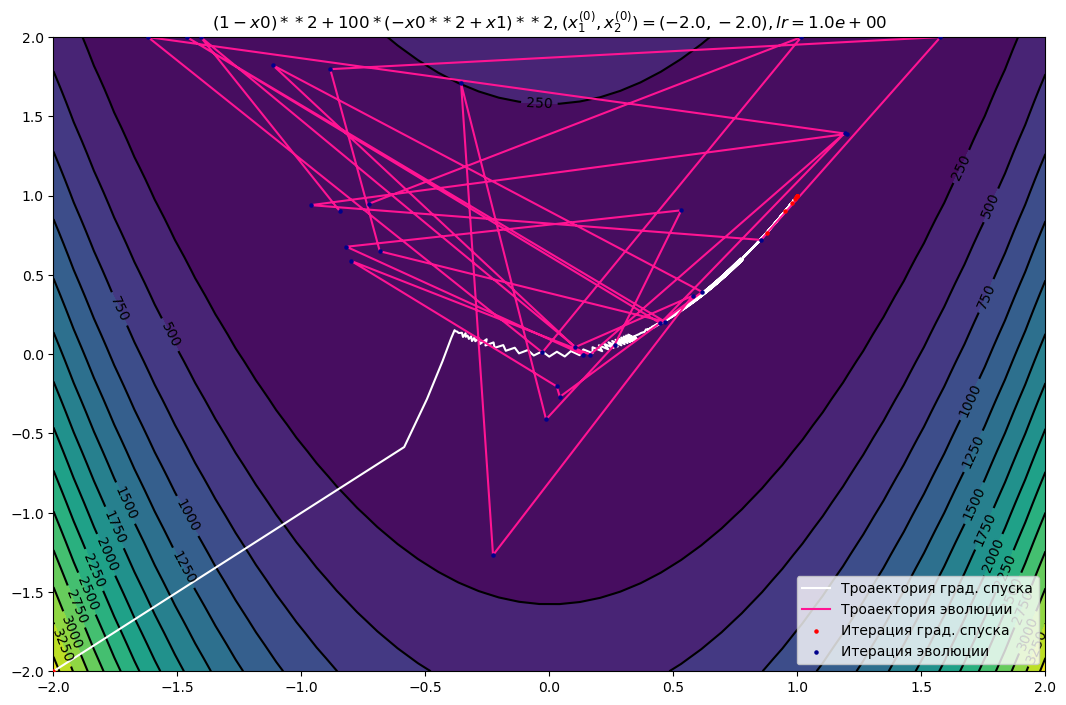

In [29]:
#%% Визуализация для функции двух аргументов через линии уровня

print("Градиентный Спуск: {:f}, Pygmo: {:f}".format(expr_eval(f, grad_res[-1, :]),
                                                    pop.champion_f[0]))

n_levels = 15 # число линий уровня
markersize = 5

indicies_grad = skip_indicies(n_grad, skip_grad)
indicies_pygmo = skip_indicies(n_pygmo, skip_pygmo)

z = np.zeros((len(y), len(x)), dtype=np.double)

for iy in range(len(y)):
    for ix in range(len(x)):
        z[iy, ix] = expr_eval(f, (x[ix], y[iy]))

fig, ax = plt.subplots(figsize=(12.80, 8.40), dpi=100)


ax.contourf(*np.meshgrid(x, y), z,
            levels=n_levels)

CS = ax.contour(*np.meshgrid(x, y), z,
                levels = n_levels,
                colors=[(0, 0, 0)] * n_levels)
ax.clabel(CS)

ax.scatter(grad_res[indicies_grad, 0], grad_res[indicies_grad, 1], color=normalize(Red), s=markersize, label="Итерация град. спуска", zorder=3)
ax.plot(grad_res[:, 0], grad_res[:, 1], color=normalize(White), label="Троаектория град. спуска")

ax.scatter(pop.get_x()[indicies_pygmo, 0], pop.get_x()[indicies_pygmo, 1], color=normalize(DarkBlue), s=markersize, label="Итерация эволюции", zorder=3)
ax.plot(pop.get_x()[indicies_pygmo, 0], pop.get_x()[indicies_pygmo, 1], color=normalize(DeepPink), label="Троаектория эволюции")

plt.legend()
plt.title(title_text)

In [31]:
#%% Визуализация для функции двух аргументов через 3D модель

print("Градиентный Спуск: {:f}, Pygmo: {:f}".format(expr_eval(f, grad_res[-1, :]),
                                                    pop.champion_f[0]))

marker_size = 4
line_width = 3
opacity = 0.6

indicies_grad = skip_indicies(n_grad, skip_grad)
indicies_pygmo = skip_indicies(n_pygmo, skip_pygmo)

z = np.zeros((len(y), len(x)), dtype=np.double)

for iy in range(len(y)):
    for ix in range(len(x)):
        z[iy, ix] = expr_eval(f, (x[ix], y[iy]))

fig = go.Figure([go.Surface(x = x,
                            y = y,
                            z = z,
                            opacity=opacity),
                 go.Scatter3d(x = grad_res[:, 0],
                              y = grad_res[:, 1],
                              z = [expr_eval(f, grad_res[i, :]) for i in range(n_grad)],
                              mode="lines",
                              line={'width': line_width, 'color': 'rgb'+str(White)},
                              name='Траектория град. спуска'),
                 go.Scatter3d(x = grad_res[indicies_grad, 0],
                              y = grad_res[indicies_grad, 1],
                              z = [expr_eval(f, grad_res[i, :]) for i in indicies_grad],
                              mode="markers",
                              marker={'size': marker_size, 'color': 'rgb'+str(Red)},
                              name="Итерация град. спуска"),
                 go.Scatter3d(x = pop.get_x()[indicies_pygmo, 0],
                              y = pop.get_x()[indicies_pygmo, 1],
                              z = pop.get_f()[indicies_pygmo, 0],
                              mode="lines",
                              line={'width': line_width, 'color': 'rgb'+str(DeepPink)},
                              name='Траектория эволюции'),
                 go.Scatter3d(x = pop.get_x()[indicies_pygmo, 0],
                              y = pop.get_x()[indicies_pygmo, 1],
                              z = pop.get_f()[indicies_pygmo, 0],
                              mode="markers",
                              marker={'size': marker_size, 'color': 'rgb'+str(DarkBlue)},
                              name="Итерация эволюции")
                ])

fig.update_layout(title ={ 'text': title_text,  'font': { 'size': 15 } },
                  legend={ 'orientation': "h",
                           'yanchor': "bottom",
                           'y': 1.02,
                           'xanchor': "right",
                           'x': 1,
                           'bgcolor': "LightSteelBlue",
                           'bordercolor': "Black",
                           'borderwidth': 2 }
                 )
fig.show()

# Сохранение на диск
path = "grad_descent.html"

fig.update_layout(width=1920, height=1080)
plot(fig, auto_open=False, filename=path, include_mathjax="cdn")

webbrowser.open_new_tab(path)

Градиентный Спуск: 0.000000, Pygmo: 0.001084


True